### **GETTING FILES**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [4]:
cp FINAL_DATA_SAAII.zip /content

In [12]:
!unzip FINAL_DATA_SAAII.zip

Streaming output truncated to the last 5000 lines.
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2635.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2641.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2646.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2651.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2662.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2666.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2667.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2668.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2672.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2674.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2676.png  
  inflating: Comprehensive Disaster Dataset(CDD)/Non_Damage/06_02_2682.png  
  inflating: Comprehensiv

In [6]:
rm -rf FINAL_DATA_SAAII.zip

In [9]:
cd ..

/content/gdrive


In [10]:
cd ..

/content


### **IMPORTING LIBRARIES AND ANALYSIS OF DATA DISTRIBUTION**

In [84]:
import os
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms.transforms import ToPILImage
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import pandas as pd
from collections import namedtuple
import torchvision.transforms as transforms
import numpy as np
import time
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import sys
import math
import warnings
warnings.filterwarnings("ignore")
bar_format = '{desc:<5.5}{percentage:3.0f}%|{bar:10}{r_bar}'

path = '/content/Comprehensive Disaster Dataset(CDD)'

In [16]:
data = ImageFolder(root=path)
print(data)
print(data.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 13557
    Root location: /content/Comprehensive Disaster Dataset(CDD)
{'Damaged_Infrastructure': 0, 'Fire_Disaster': 1, 'Human_Damage': 2, 'Land_Disaster': 3, 'Non_Damage': 4, 'Water_Disaster': 5}


In [17]:
class DisasterData(Dataset):
  def __init__(self, data, transform):
    self.data = data
    self.transform = transform
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    image, label = self.data[idx][0], self.data[idx][1]
    if self.transform:
      image = self.transform(image)
    else:
      image = transforms.ToTensor()(image)
    return image, label

Damaged_Infrastructure (0) : 1454
Fire_Disaster (1) : 933
Human_Damage (2) : 241
Land_Disaster (3) : 657
Non_Damage (4) : 9237
Water_Disaster (5) : 1035


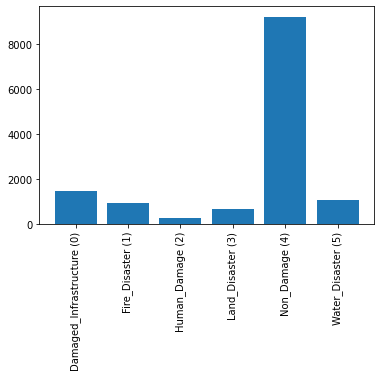

In [20]:
def count_files(path):
  file_paths = []
  for (_, _, file_names) in os.walk(path):
      file_paths.extend(file_names)
  return len(file_paths)

def count_dist_classes(master_path, data):
  classes = data.classes
  dist = {}
  for label , label_idx in zip(classes, list(data.class_to_idx.values())):
    class_path = os.path.join(master_path, label)
    key = f"{label} ({label_idx})"
    value = count_files(class_path)
    dist[key] = value
    print(f"{label} ({label_idx}) : {count_files(class_path)}")
  return dist


def plot_dist(dist):
  plt.bar(height=list(dist.values()), x = list(dist.keys()))
  plt.xticks(rotation=90)

dist = count_dist_classes(path, data)
plot_dist(dist)

In [21]:
non_damage_path = os.path.join(path, 'Non_Damage')

### **Making collages to down sample the images**

In [28]:
from random import random
from random import sample
from PIL import Image

path_non_damage = os.path.join(path, 'Non_Damage')
files_non_damage = os.listdir(path_non_damage)

In [ ]:
sample_images = sample(files_non_damage, 9)
collage_sample = Image.new("RGB", (3072, 3072), color = (225,225,225))

c = 0
for i in range(0, 3072, 1024):
  for j in range(0, 3072, 1024):
    print(c)
    file = os.path.join(path_non_damage, sample_images[c])
    image = Image.open(file).convert("RGB")
    image = image.resize((1024,1024))

    collage_sample.paste(image, (i, j))
    c+= 1

collage_sample.save(os.path.join('/content', 'pila.png'))

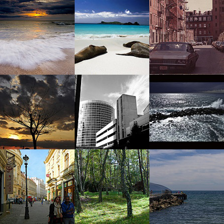

In [48]:
collage_sample.resize((224,224))

In [79]:
def make_random_collages(master_path, image_folder_path, num_images=9, rows=3, each_image_size = 1024, save_image_size=224, save_image=None, delete_samples=False):
  path_images = os.path.join(master_path, image_folder_path)
  files = os.listdir(path_images)
  sample_images = sample(files, num_images)
  
  collage_image_size = each_image_size * rows
  collage_sample = Image.new("RGB", (collage_image_size, collage_image_size), color = (255,255,255))
  
  c = 0
  for i in range(0, collage_image_size, each_image_size):
    for j in range(0, collage_image_size, each_image_size):
      file = os.path.join(path_images, sample_images[c])
      image = Image.open(file).convert("RGB")
      image = image.resize((each_image_size, each_image_size))

      collage_sample.paste(image, (i, j))
      c += 1
  
  collage_sample = collage_sample.resize((save_image_size, save_image_size))
  if save_image:
    collage_sample.save(save_image)
  if delete_samples:
    for imgs in sample_images:
      path_to_delete = os.path.join(path_images, imgs)
      os.remove(path_to_delete)
    print('Samples deleted')
  return collage_sample

In [76]:
sample_img = make_random_collages(
                master_path = path,
                image_folder_path = 'Non_Damage',
                delete_samples = True
              )

Samples deleted


In [85]:
master_path = path
image_folder = 'Non_Damage'

for i in tqdm(range(1000), bar_format=bar_format):
  name = f'collage_{image_folder}_{i}.png'
  path_to_save = os.path.join(master_path, image_folder, name)
  sample_image = make_random_collages(
      master_path = master_path,
      image_folder_path = image_folder,
      delete_samples = True,
      save_image = path_to_save
  )

       0%|          | 1/1000 [00:00<03:54,  4.26it/s]

Samples deleted


       0%|          | 2/1000 [00:00<03:54,  4.25it/s]

Samples deleted


       0%|          | 3/1000 [00:00<03:47,  4.39it/s]

Samples deleted


       0%|          | 4/1000 [00:00<03:43,  4.45it/s]

Samples deleted


       0%|          | 5/1000 [00:01<03:56,  4.20it/s]

Samples deleted


       1%|          | 6/1000 [00:01<03:51,  4.29it/s]

Samples deleted


       1%|          | 7/1000 [00:01<03:48,  4.35it/s]

Samples deleted


       1%|          | 8/1000 [00:01<03:48,  4.34it/s]

Samples deleted


       1%|          | 9/1000 [00:02<03:45,  4.40it/s]

Samples deleted


       1%|          | 10/1000 [00:02<03:48,  4.33it/s]

Samples deleted


       1%|          | 11/1000 [00:02<03:47,  4.35it/s]

Samples deleted


       1%|          | 12/1000 [00:02<03:51,  4.27it/s]

Samples deleted


       1%|▏         | 13/1000 [00:03<03:54,  4.21it/s]

Samples deleted


       1%|▏         | 14/1000 [00:03<03:54,  4.21it/s]

Samples deleted


       2%|▏         | 15/1000 [00:03<03:49,  4.29it/s]

Samples deleted


       2%|▏         | 16/1000 [00:03<03:46,  4.34it/s]

Samples deleted


       2%|▏         | 17/1000 [00:03<03:45,  4.36it/s]

Samples deleted


       2%|▏         | 18/1000 [00:04<03:45,  4.36it/s]

Samples deleted


       2%|▏         | 19/1000 [00:04<03:42,  4.41it/s]

Samples deleted


       2%|▏         | 20/1000 [00:04<03:45,  4.34it/s]

Samples deleted


       2%|▏         | 21/1000 [00:04<03:43,  4.39it/s]

Samples deleted


       2%|▏         | 22/1000 [00:05<03:42,  4.40it/s]

Samples deleted


       2%|▏         | 23/1000 [00:05<03:44,  4.35it/s]

Samples deleted


       2%|▏         | 24/1000 [00:05<03:44,  4.35it/s]

Samples deleted


       2%|▎         | 25/1000 [00:05<03:46,  4.31it/s]

Samples deleted


       3%|▎         | 26/1000 [00:06<03:45,  4.32it/s]

Samples deleted


       3%|▎         | 27/1000 [00:06<03:44,  4.32it/s]

Samples deleted


       3%|▎         | 28/1000 [00:06<03:52,  4.18it/s]

Samples deleted


       3%|▎         | 29/1000 [00:06<03:48,  4.25it/s]

Samples deleted


       3%|▎         | 30/1000 [00:06<03:45,  4.30it/s]

Samples deleted


       3%|▎         | 31/1000 [00:07<03:43,  4.34it/s]

Samples deleted


       3%|▎         | 32/1000 [00:07<03:45,  4.29it/s]

Samples deleted


       3%|▎         | 33/1000 [00:07<03:46,  4.27it/s]

Samples deleted


       3%|▎         | 34/1000 [00:07<03:44,  4.29it/s]

Samples deleted


       4%|▎         | 35/1000 [00:08<03:44,  4.29it/s]

Samples deleted


       4%|▎         | 36/1000 [00:08<03:45,  4.28it/s]

Samples deleted


       4%|▎         | 37/1000 [00:08<03:44,  4.29it/s]

Samples deleted


       4%|▍         | 38/1000 [00:08<03:41,  4.33it/s]

Samples deleted


       4%|▍         | 39/1000 [00:09<03:40,  4.37it/s]

Samples deleted


       4%|▍         | 40/1000 [00:09<03:43,  4.30it/s]

Samples deleted


       4%|▍         | 41/1000 [00:09<03:42,  4.31it/s]

Samples deleted


       4%|▍         | 42/1000 [00:09<03:42,  4.30it/s]

Samples deleted


       4%|▍         | 43/1000 [00:09<03:44,  4.26it/s]

Samples deleted


       4%|▍         | 44/1000 [00:10<03:43,  4.27it/s]

Samples deleted


       4%|▍         | 45/1000 [00:10<03:44,  4.25it/s]

Samples deleted


       5%|▍         | 46/1000 [00:10<03:42,  4.28it/s]

Samples deleted


       5%|▍         | 47/1000 [00:10<03:41,  4.29it/s]

Samples deleted


       5%|▍         | 48/1000 [00:11<03:40,  4.32it/s]

Samples deleted


       5%|▍         | 49/1000 [00:11<03:39,  4.32it/s]

Samples deleted


       5%|▌         | 50/1000 [00:11<03:37,  4.37it/s]

Samples deleted


       5%|▌         | 51/1000 [00:11<03:36,  4.39it/s]

Samples deleted


       5%|▌         | 52/1000 [00:12<03:38,  4.33it/s]

Samples deleted


       5%|▌         | 53/1000 [00:12<03:39,  4.31it/s]

Samples deleted


       5%|▌         | 54/1000 [00:12<03:39,  4.32it/s]

Samples deleted


       6%|▌         | 55/1000 [00:12<03:37,  4.35it/s]

Samples deleted


       6%|▌         | 56/1000 [00:12<03:36,  4.37it/s]

Samples deleted


       6%|▌         | 57/1000 [00:13<03:37,  4.33it/s]

Samples deleted


       6%|▌         | 58/1000 [00:13<03:39,  4.29it/s]

Samples deleted


       6%|▌         | 59/1000 [00:13<03:41,  4.25it/s]

Samples deleted


       6%|▌         | 60/1000 [00:13<03:41,  4.25it/s]

Samples deleted


       6%|▌         | 61/1000 [00:14<03:41,  4.24it/s]

Samples deleted


       6%|▌         | 62/1000 [00:14<03:40,  4.25it/s]

Samples deleted


       6%|▋         | 63/1000 [00:14<03:38,  4.29it/s]

Samples deleted


       6%|▋         | 64/1000 [00:14<03:36,  4.31it/s]

Samples deleted


       6%|▋         | 65/1000 [00:15<03:35,  4.34it/s]

Samples deleted


       7%|▋         | 66/1000 [00:15<03:35,  4.33it/s]

Samples deleted


       7%|▋         | 67/1000 [00:15<03:35,  4.34it/s]

Samples deleted


       7%|▋         | 68/1000 [00:15<03:32,  4.38it/s]

Samples deleted


       7%|▋         | 69/1000 [00:15<03:33,  4.36it/s]

Samples deleted


       7%|▋         | 70/1000 [00:16<03:37,  4.27it/s]

Samples deleted


       7%|▋         | 71/1000 [00:16<03:42,  4.17it/s]

Samples deleted


       7%|▋         | 72/1000 [00:16<03:40,  4.22it/s]

Samples deleted


       7%|▋         | 73/1000 [00:16<03:38,  4.24it/s]

Samples deleted


       7%|▋         | 74/1000 [00:17<03:40,  4.20it/s]

Samples deleted


       8%|▊         | 75/1000 [00:17<03:43,  4.14it/s]

Samples deleted


       8%|▊         | 76/1000 [00:17<03:46,  4.09it/s]

Samples deleted


       8%|▊         | 77/1000 [00:17<03:46,  4.07it/s]

Samples deleted


       8%|▊         | 78/1000 [00:18<03:43,  4.13it/s]

Samples deleted


       8%|▊         | 79/1000 [00:18<03:42,  4.14it/s]

Samples deleted


       8%|▊         | 80/1000 [00:18<03:41,  4.15it/s]

Samples deleted


       8%|▊         | 81/1000 [00:18<03:40,  4.16it/s]

Samples deleted


       8%|▊         | 82/1000 [00:19<03:39,  4.18it/s]

Samples deleted


       8%|▊         | 83/1000 [00:19<03:41,  4.13it/s]

Samples deleted


       8%|▊         | 84/1000 [00:19<03:41,  4.14it/s]

Samples deleted


       8%|▊         | 85/1000 [00:19<03:42,  4.12it/s]

Samples deleted


       9%|▊         | 86/1000 [00:20<03:40,  4.15it/s]

Samples deleted


       9%|▊         | 87/1000 [00:20<03:42,  4.11it/s]

Samples deleted


       9%|▉         | 88/1000 [00:20<03:39,  4.15it/s]

Samples deleted


       9%|▉         | 89/1000 [00:20<03:36,  4.21it/s]

Samples deleted


       9%|▉         | 90/1000 [00:21<03:31,  4.30it/s]

Samples deleted


       9%|▉         | 91/1000 [00:21<03:29,  4.33it/s]

Samples deleted


       9%|▉         | 92/1000 [00:21<03:28,  4.35it/s]

Samples deleted


       9%|▉         | 93/1000 [00:21<03:31,  4.29it/s]

Samples deleted


       9%|▉         | 94/1000 [00:21<03:29,  4.32it/s]

Samples deleted


      10%|▉         | 95/1000 [00:22<03:27,  4.36it/s]

Samples deleted


      10%|▉         | 96/1000 [00:22<03:27,  4.36it/s]

Samples deleted


      10%|▉         | 97/1000 [00:22<03:29,  4.31it/s]

Samples deleted


      10%|▉         | 98/1000 [00:22<03:30,  4.29it/s]

Samples deleted


      10%|▉         | 99/1000 [00:23<03:27,  4.33it/s]

Samples deleted


      10%|█         | 100/1000 [00:23<03:25,  4.37it/s]

Samples deleted


      10%|█         | 101/1000 [00:23<03:25,  4.36it/s]

Samples deleted


      10%|█         | 102/1000 [00:23<03:24,  4.39it/s]

Samples deleted


      10%|█         | 103/1000 [00:24<03:26,  4.35it/s]

Samples deleted


      10%|█         | 104/1000 [00:24<03:30,  4.26it/s]

Samples deleted


      10%|█         | 105/1000 [00:24<03:31,  4.22it/s]

Samples deleted


      11%|█         | 106/1000 [00:24<03:29,  4.27it/s]

Samples deleted


      11%|█         | 107/1000 [00:24<03:28,  4.29it/s]

Samples deleted


      11%|█         | 108/1000 [00:25<03:27,  4.30it/s]

Samples deleted


      11%|█         | 109/1000 [00:25<03:28,  4.26it/s]

Samples deleted


      11%|█         | 110/1000 [00:25<03:26,  4.31it/s]

Samples deleted


      11%|█         | 111/1000 [00:25<03:26,  4.31it/s]

Samples deleted


      11%|█         | 112/1000 [00:26<03:26,  4.30it/s]

Samples deleted


      11%|█▏        | 113/1000 [00:26<03:25,  4.31it/s]

Samples deleted


      11%|█▏        | 114/1000 [00:26<03:27,  4.26it/s]

Samples deleted


      12%|█▏        | 115/1000 [00:26<03:27,  4.27it/s]

Samples deleted


      12%|█▏        | 116/1000 [00:27<03:26,  4.29it/s]

Samples deleted


      12%|█▏        | 117/1000 [00:27<03:26,  4.28it/s]

Samples deleted


      12%|█▏        | 118/1000 [00:27<03:27,  4.25it/s]

Samples deleted


      12%|█▏        | 119/1000 [00:27<03:25,  4.28it/s]

Samples deleted


      12%|█▏        | 120/1000 [00:28<03:23,  4.33it/s]

Samples deleted


      12%|█▏        | 121/1000 [00:28<03:22,  4.35it/s]

Samples deleted


      12%|█▏        | 122/1000 [00:28<03:22,  4.33it/s]

Samples deleted


      12%|█▏        | 123/1000 [00:28<03:26,  4.25it/s]

Samples deleted


      12%|█▏        | 124/1000 [00:28<03:24,  4.28it/s]

Samples deleted


      12%|█▎        | 125/1000 [00:29<03:26,  4.24it/s]

Samples deleted


      13%|█▎        | 126/1000 [00:29<03:24,  4.27it/s]

Samples deleted


      13%|█▎        | 127/1000 [00:29<03:25,  4.26it/s]

Samples deleted


      13%|█▎        | 128/1000 [00:29<03:21,  4.33it/s]

Samples deleted


      13%|█▎        | 129/1000 [00:30<03:20,  4.35it/s]

Samples deleted


      13%|█▎        | 130/1000 [00:30<03:20,  4.33it/s]

Samples deleted


      13%|█▎        | 131/1000 [00:30<03:21,  4.32it/s]

Samples deleted


      13%|█▎        | 132/1000 [00:30<03:19,  4.35it/s]

Samples deleted


      13%|█▎        | 133/1000 [00:31<03:16,  4.41it/s]

Samples deleted


      13%|█▎        | 134/1000 [00:31<03:15,  4.44it/s]

Samples deleted


      14%|█▎        | 135/1000 [00:31<03:16,  4.40it/s]

Samples deleted


      14%|█▎        | 136/1000 [00:31<03:18,  4.34it/s]

Samples deleted


      14%|█▎        | 137/1000 [00:31<03:18,  4.35it/s]

Samples deleted


      14%|█▍        | 138/1000 [00:32<03:18,  4.34it/s]

Samples deleted


      14%|█▍        | 139/1000 [00:32<03:18,  4.34it/s]

Samples deleted


      14%|█▍        | 140/1000 [00:32<03:16,  4.39it/s]

Samples deleted


      14%|█▍        | 141/1000 [00:32<03:20,  4.28it/s]

Samples deleted


      14%|█▍        | 142/1000 [00:33<03:20,  4.28it/s]

Samples deleted


      14%|█▍        | 143/1000 [00:33<03:17,  4.35it/s]

Samples deleted


      14%|█▍        | 144/1000 [00:33<03:16,  4.35it/s]

Samples deleted


      14%|█▍        | 145/1000 [00:33<03:15,  4.37it/s]

Samples deleted


      15%|█▍        | 146/1000 [00:34<03:15,  4.37it/s]

Samples deleted


      15%|█▍        | 147/1000 [00:34<03:13,  4.42it/s]

Samples deleted


      15%|█▍        | 148/1000 [00:34<03:14,  4.39it/s]

Samples deleted


      15%|█▍        | 149/1000 [00:34<03:18,  4.29it/s]

Samples deleted


      15%|█▌        | 150/1000 [00:34<03:17,  4.31it/s]

Samples deleted


      15%|█▌        | 151/1000 [00:35<03:15,  4.34it/s]

Samples deleted


      15%|█▌        | 152/1000 [00:35<03:14,  4.35it/s]

Samples deleted


      15%|█▌        | 153/1000 [00:35<03:15,  4.32it/s]

Samples deleted


      15%|█▌        | 154/1000 [00:35<03:13,  4.38it/s]

Samples deleted


      16%|█▌        | 155/1000 [00:36<03:11,  4.41it/s]

Samples deleted


      16%|█▌        | 156/1000 [00:36<03:16,  4.30it/s]

Samples deleted


      16%|█▌        | 157/1000 [00:36<03:14,  4.32it/s]

Samples deleted


      16%|█▌        | 158/1000 [00:36<03:14,  4.34it/s]

Samples deleted


      16%|█▌        | 159/1000 [00:36<03:11,  4.40it/s]

Samples deleted


      16%|█▌        | 160/1000 [00:37<03:11,  4.38it/s]

Samples deleted


      16%|█▌        | 161/1000 [00:37<03:11,  4.39it/s]

Samples deleted


      16%|█▌        | 162/1000 [00:37<03:11,  4.38it/s]

Samples deleted


      16%|█▋        | 163/1000 [00:37<03:10,  4.39it/s]

Samples deleted


      16%|█▋        | 164/1000 [00:38<03:10,  4.40it/s]

Samples deleted


      16%|█▋        | 165/1000 [00:38<03:09,  4.40it/s]

Samples deleted


      17%|█▋        | 166/1000 [00:38<03:08,  4.41it/s]

Samples deleted


      17%|█▋        | 167/1000 [00:38<03:08,  4.42it/s]

Samples deleted


      17%|█▋        | 168/1000 [00:39<03:06,  4.47it/s]

Samples deleted


      17%|█▋        | 169/1000 [00:39<03:10,  4.37it/s]

Samples deleted


      17%|█▋        | 170/1000 [00:39<03:09,  4.37it/s]

Samples deleted


      17%|█▋        | 171/1000 [00:39<03:13,  4.29it/s]

Samples deleted


      17%|█▋        | 172/1000 [00:39<03:14,  4.25it/s]

Samples deleted


      17%|█▋        | 173/1000 [00:40<03:13,  4.27it/s]

Samples deleted


      17%|█▋        | 174/1000 [00:40<03:12,  4.29it/s]

Samples deleted


      18%|█▊        | 175/1000 [00:40<03:10,  4.32it/s]

Samples deleted


      18%|█▊        | 176/1000 [00:40<03:09,  4.34it/s]

Samples deleted


      18%|█▊        | 177/1000 [00:41<03:10,  4.33it/s]

Samples deleted


      18%|█▊        | 178/1000 [00:41<03:09,  4.33it/s]

Samples deleted


      18%|█▊        | 179/1000 [00:41<03:08,  4.36it/s]

Samples deleted


      18%|█▊        | 180/1000 [00:41<03:06,  4.39it/s]

Samples deleted


      18%|█▊        | 181/1000 [00:42<03:08,  4.35it/s]

Samples deleted


      18%|█▊        | 182/1000 [00:42<03:14,  4.21it/s]

Samples deleted


      18%|█▊        | 183/1000 [00:42<03:12,  4.25it/s]

Samples deleted


      18%|█▊        | 184/1000 [00:42<03:10,  4.27it/s]

Samples deleted


      18%|█▊        | 185/1000 [00:42<03:10,  4.28it/s]

Samples deleted


      19%|█▊        | 186/1000 [00:43<03:08,  4.31it/s]

Samples deleted


      19%|█▊        | 187/1000 [00:43<03:10,  4.27it/s]

Samples deleted


      19%|█▉        | 188/1000 [00:43<03:08,  4.31it/s]

Samples deleted


      19%|█▉        | 189/1000 [00:43<03:08,  4.30it/s]

Samples deleted


      19%|█▉        | 190/1000 [00:44<03:08,  4.30it/s]

Samples deleted


      19%|█▉        | 191/1000 [00:44<03:06,  4.34it/s]

Samples deleted


      19%|█▉        | 192/1000 [00:44<03:06,  4.33it/s]

Samples deleted


      19%|█▉        | 193/1000 [00:44<03:07,  4.30it/s]

Samples deleted


      19%|█▉        | 194/1000 [00:45<03:10,  4.22it/s]

Samples deleted


      20%|█▉        | 195/1000 [00:45<03:11,  4.21it/s]

Samples deleted


      20%|█▉        | 196/1000 [00:45<03:09,  4.23it/s]

Samples deleted


      20%|█▉        | 197/1000 [00:45<03:11,  4.20it/s]

Samples deleted


      20%|█▉        | 198/1000 [00:46<03:10,  4.21it/s]

Samples deleted


      20%|█▉        | 199/1000 [00:46<03:14,  4.12it/s]

Samples deleted


      20%|██        | 200/1000 [00:46<03:11,  4.17it/s]

Samples deleted


      20%|██        | 201/1000 [00:46<03:08,  4.24it/s]

Samples deleted


      20%|██        | 202/1000 [00:46<03:06,  4.28it/s]

Samples deleted


      20%|██        | 203/1000 [00:47<03:03,  4.34it/s]

Samples deleted


      20%|██        | 204/1000 [00:47<03:04,  4.32it/s]

Samples deleted


      20%|██        | 205/1000 [00:47<03:04,  4.30it/s]

Samples deleted


      21%|██        | 206/1000 [00:47<03:04,  4.30it/s]

Samples deleted


      21%|██        | 207/1000 [00:48<03:04,  4.29it/s]

Samples deleted


      21%|██        | 208/1000 [00:48<03:02,  4.34it/s]

Samples deleted


      21%|██        | 209/1000 [00:48<03:01,  4.37it/s]

Samples deleted


      21%|██        | 210/1000 [00:48<03:02,  4.33it/s]

Samples deleted


      21%|██        | 211/1000 [00:49<03:04,  4.28it/s]

Samples deleted


      21%|██        | 212/1000 [00:49<03:05,  4.26it/s]

Samples deleted


      21%|██▏       | 213/1000 [00:49<03:03,  4.30it/s]

Samples deleted


      21%|██▏       | 214/1000 [00:49<03:03,  4.28it/s]

Samples deleted


      22%|██▏       | 215/1000 [00:50<03:05,  4.22it/s]

Samples deleted


      22%|██▏       | 216/1000 [00:50<03:06,  4.20it/s]

Samples deleted


      22%|██▏       | 217/1000 [00:50<03:07,  4.18it/s]

Samples deleted


      22%|██▏       | 218/1000 [00:50<03:07,  4.18it/s]

Samples deleted


      22%|██▏       | 219/1000 [00:51<03:13,  4.04it/s]

Samples deleted


      22%|██▏       | 220/1000 [00:51<03:09,  4.11it/s]

Samples deleted


      22%|██▏       | 221/1000 [00:51<03:07,  4.17it/s]

Samples deleted


      22%|██▏       | 222/1000 [00:51<03:06,  4.18it/s]

Samples deleted


      22%|██▏       | 223/1000 [00:51<03:06,  4.17it/s]

Samples deleted


      22%|██▏       | 224/1000 [00:52<03:05,  4.18it/s]

Samples deleted


      22%|██▎       | 225/1000 [00:52<03:03,  4.21it/s]

Samples deleted


      23%|██▎       | 226/1000 [00:52<03:09,  4.08it/s]

Samples deleted


      23%|██▎       | 227/1000 [00:52<03:07,  4.12it/s]

Samples deleted


      23%|██▎       | 228/1000 [00:53<03:05,  4.15it/s]

Samples deleted


      23%|██▎       | 229/1000 [00:53<03:05,  4.16it/s]

Samples deleted


      23%|██▎       | 230/1000 [00:53<03:09,  4.07it/s]

Samples deleted


      23%|██▎       | 231/1000 [00:53<03:08,  4.09it/s]

Samples deleted


      23%|██▎       | 232/1000 [00:54<03:05,  4.14it/s]

Samples deleted


      23%|██▎       | 233/1000 [00:54<03:04,  4.16it/s]

Samples deleted


      23%|██▎       | 234/1000 [00:54<03:03,  4.18it/s]

Samples deleted


      24%|██▎       | 235/1000 [00:54<03:00,  4.24it/s]

Samples deleted


      24%|██▎       | 236/1000 [00:55<03:01,  4.21it/s]

Samples deleted


      24%|██▎       | 237/1000 [00:55<03:01,  4.20it/s]

Samples deleted


      24%|██▍       | 238/1000 [00:55<03:02,  4.19it/s]

Samples deleted


      24%|██▍       | 239/1000 [00:55<03:03,  4.14it/s]

Samples deleted


      24%|██▍       | 240/1000 [00:56<03:03,  4.14it/s]

Samples deleted


      24%|██▍       | 241/1000 [00:56<03:01,  4.19it/s]

Samples deleted


      24%|██▍       | 242/1000 [00:56<02:59,  4.22it/s]

Samples deleted


      24%|██▍       | 243/1000 [00:56<03:01,  4.18it/s]

Samples deleted


      24%|██▍       | 244/1000 [00:57<03:03,  4.12it/s]

Samples deleted


      24%|██▍       | 245/1000 [00:57<03:03,  4.12it/s]

Samples deleted


      25%|██▍       | 246/1000 [00:57<03:01,  4.16it/s]

Samples deleted


      25%|██▍       | 247/1000 [00:57<03:01,  4.16it/s]

Samples deleted


      25%|██▍       | 248/1000 [00:57<03:00,  4.17it/s]

Samples deleted


      25%|██▍       | 249/1000 [00:58<02:59,  4.19it/s]

Samples deleted


      25%|██▌       | 250/1000 [00:58<02:56,  4.26it/s]

Samples deleted


      25%|██▌       | 251/1000 [00:58<02:55,  4.27it/s]

Samples deleted


      25%|██▌       | 252/1000 [00:58<02:54,  4.29it/s]

Samples deleted


      25%|██▌       | 253/1000 [00:59<02:55,  4.26it/s]

Samples deleted


      25%|██▌       | 254/1000 [00:59<02:56,  4.22it/s]

Samples deleted


      26%|██▌       | 255/1000 [00:59<02:54,  4.26it/s]

Samples deleted


      26%|██▌       | 256/1000 [00:59<02:59,  4.15it/s]

Samples deleted


      26%|██▌       | 257/1000 [01:00<02:58,  4.17it/s]

Samples deleted


      26%|██▌       | 258/1000 [01:00<02:54,  4.24it/s]

Samples deleted


      26%|██▌       | 259/1000 [01:00<02:54,  4.25it/s]

Samples deleted


      26%|██▌       | 260/1000 [01:00<02:51,  4.33it/s]

Samples deleted


      26%|██▌       | 261/1000 [01:00<02:50,  4.34it/s]

Samples deleted


      26%|██▌       | 262/1000 [01:01<02:50,  4.32it/s]

Samples deleted


      26%|██▋       | 263/1000 [01:01<02:49,  4.35it/s]

Samples deleted


      26%|██▋       | 264/1000 [01:01<02:50,  4.31it/s]

Samples deleted


      26%|██▋       | 265/1000 [01:01<02:48,  4.36it/s]

Samples deleted


      27%|██▋       | 266/1000 [01:02<02:51,  4.29it/s]

Samples deleted


      27%|██▋       | 267/1000 [01:02<02:50,  4.30it/s]

Samples deleted


      27%|██▋       | 268/1000 [01:02<02:47,  4.36it/s]

Samples deleted


      27%|██▋       | 269/1000 [01:02<02:47,  4.36it/s]

Samples deleted


      27%|██▋       | 270/1000 [01:03<02:50,  4.29it/s]

Samples deleted


      27%|██▋       | 271/1000 [01:03<02:47,  4.36it/s]

Samples deleted


      27%|██▋       | 272/1000 [01:03<02:45,  4.40it/s]

Samples deleted


      27%|██▋       | 273/1000 [01:03<02:44,  4.41it/s]

Samples deleted


      27%|██▋       | 274/1000 [01:03<02:47,  4.34it/s]

Samples deleted


      28%|██▊       | 275/1000 [01:04<02:47,  4.32it/s]

Samples deleted


      28%|██▊       | 276/1000 [01:04<02:46,  4.36it/s]

Samples deleted


      28%|██▊       | 277/1000 [01:04<02:44,  4.38it/s]

Samples deleted


      28%|██▊       | 278/1000 [01:04<02:45,  4.35it/s]

Samples deleted


      28%|██▊       | 279/1000 [01:05<02:47,  4.31it/s]

Samples deleted


      28%|██▊       | 280/1000 [01:05<02:46,  4.34it/s]

Samples deleted


      28%|██▊       | 281/1000 [01:05<02:47,  4.29it/s]

Samples deleted


      28%|██▊       | 282/1000 [01:05<02:44,  4.36it/s]

Samples deleted


      28%|██▊       | 283/1000 [01:06<02:47,  4.28it/s]

Samples deleted


      28%|██▊       | 284/1000 [01:06<02:48,  4.24it/s]

Samples deleted


      28%|██▊       | 285/1000 [01:06<02:47,  4.28it/s]

Samples deleted


      29%|██▊       | 286/1000 [01:06<02:46,  4.30it/s]

Samples deleted


      29%|██▊       | 287/1000 [01:06<02:43,  4.36it/s]

Samples deleted


      29%|██▉       | 288/1000 [01:07<02:44,  4.33it/s]

Samples deleted


      29%|██▉       | 289/1000 [01:07<02:42,  4.38it/s]

Samples deleted


      29%|██▉       | 290/1000 [01:07<02:42,  4.37it/s]

Samples deleted


      29%|██▉       | 291/1000 [01:07<02:42,  4.36it/s]

Samples deleted


      29%|██▉       | 292/1000 [01:08<02:43,  4.32it/s]

Samples deleted


      29%|██▉       | 293/1000 [01:08<02:46,  4.24it/s]

Samples deleted


      29%|██▉       | 294/1000 [01:08<02:46,  4.24it/s]

Samples deleted


      30%|██▉       | 295/1000 [01:08<02:45,  4.26it/s]

Samples deleted


      30%|██▉       | 296/1000 [01:09<02:45,  4.26it/s]

Samples deleted


      30%|██▉       | 297/1000 [01:09<02:47,  4.20it/s]

Samples deleted


      30%|██▉       | 298/1000 [01:09<02:45,  4.24it/s]

Samples deleted


      30%|██▉       | 299/1000 [01:09<02:42,  4.31it/s]

Samples deleted


      30%|███       | 300/1000 [01:10<02:40,  4.36it/s]

Samples deleted


      30%|███       | 301/1000 [01:10<02:39,  4.38it/s]

Samples deleted


      30%|███       | 302/1000 [01:10<02:40,  4.36it/s]

Samples deleted


      30%|███       | 303/1000 [01:10<02:39,  4.36it/s]

Samples deleted


      30%|███       | 304/1000 [01:10<02:42,  4.29it/s]

Samples deleted


      30%|███       | 305/1000 [01:11<02:43,  4.25it/s]

Samples deleted


      31%|███       | 306/1000 [01:11<02:43,  4.24it/s]

Samples deleted


      31%|███       | 307/1000 [01:11<02:43,  4.24it/s]

Samples deleted


      31%|███       | 308/1000 [01:11<02:42,  4.25it/s]

Samples deleted


      31%|███       | 309/1000 [01:12<02:42,  4.25it/s]

Samples deleted


      31%|███       | 310/1000 [01:12<02:42,  4.26it/s]

Samples deleted


      31%|███       | 311/1000 [01:12<02:41,  4.26it/s]

Samples deleted


      31%|███       | 312/1000 [01:12<02:41,  4.26it/s]

Samples deleted


      31%|███▏      | 313/1000 [01:13<02:41,  4.26it/s]

Samples deleted


      31%|███▏      | 314/1000 [01:13<02:44,  4.18it/s]

Samples deleted


      32%|███▏      | 315/1000 [01:13<02:44,  4.16it/s]

Samples deleted


      32%|███▏      | 316/1000 [01:13<02:44,  4.16it/s]

Samples deleted


      32%|███▏      | 317/1000 [01:14<02:41,  4.24it/s]

Samples deleted


      32%|███▏      | 318/1000 [01:14<02:40,  4.24it/s]

Samples deleted


      32%|███▏      | 319/1000 [01:14<02:39,  4.27it/s]

Samples deleted


      32%|███▏      | 320/1000 [01:14<02:37,  4.31it/s]

Samples deleted


      32%|███▏      | 321/1000 [01:14<02:36,  4.33it/s]

Samples deleted


      32%|███▏      | 322/1000 [01:15<02:37,  4.30it/s]

Samples deleted


      32%|███▏      | 323/1000 [01:15<02:38,  4.27it/s]

Samples deleted


      32%|███▏      | 324/1000 [01:15<02:38,  4.25it/s]

Samples deleted


      32%|███▎      | 325/1000 [01:15<02:38,  4.26it/s]

Samples deleted


      33%|███▎      | 326/1000 [01:16<02:40,  4.19it/s]

Samples deleted


      33%|███▎      | 327/1000 [01:16<02:41,  4.16it/s]

Samples deleted


      33%|███▎      | 328/1000 [01:16<02:40,  4.18it/s]

Samples deleted


      33%|███▎      | 329/1000 [01:16<02:42,  4.13it/s]

Samples deleted


      33%|███▎      | 330/1000 [01:17<02:40,  4.17it/s]

Samples deleted


      33%|███▎      | 331/1000 [01:17<02:42,  4.13it/s]

Samples deleted


      33%|███▎      | 332/1000 [01:17<02:41,  4.13it/s]

Samples deleted


      33%|███▎      | 333/1000 [01:17<02:39,  4.17it/s]

Samples deleted


      33%|███▎      | 334/1000 [01:18<02:41,  4.14it/s]

Samples deleted


      34%|███▎      | 335/1000 [01:18<02:40,  4.15it/s]

Samples deleted


      34%|███▎      | 336/1000 [01:18<02:38,  4.20it/s]

Samples deleted


      34%|███▎      | 337/1000 [01:18<02:36,  4.24it/s]

Samples deleted


      34%|███▍      | 338/1000 [01:19<02:35,  4.25it/s]

Samples deleted


      34%|███▍      | 339/1000 [01:19<02:36,  4.23it/s]

Samples deleted


      34%|███▍      | 340/1000 [01:19<02:35,  4.25it/s]

Samples deleted


      34%|███▍      | 341/1000 [01:19<02:34,  4.27it/s]

Samples deleted


      34%|███▍      | 342/1000 [01:19<02:33,  4.28it/s]

Samples deleted


      34%|███▍      | 343/1000 [01:20<02:33,  4.29it/s]

Samples deleted


      34%|███▍      | 344/1000 [01:20<02:34,  4.24it/s]

Samples deleted


      34%|███▍      | 345/1000 [01:20<02:35,  4.22it/s]

Samples deleted


      35%|███▍      | 346/1000 [01:20<02:38,  4.12it/s]

Samples deleted


      35%|███▍      | 347/1000 [01:21<02:38,  4.13it/s]

Samples deleted


      35%|███▍      | 348/1000 [01:21<02:37,  4.15it/s]

Samples deleted


      35%|███▍      | 349/1000 [01:21<02:35,  4.18it/s]

Samples deleted


      35%|███▌      | 350/1000 [01:21<02:35,  4.18it/s]

Samples deleted


      35%|███▌      | 351/1000 [01:22<02:34,  4.21it/s]

Samples deleted


      35%|███▌      | 352/1000 [01:22<02:42,  3.99it/s]

Samples deleted


      35%|███▌      | 353/1000 [01:22<02:41,  4.01it/s]

Samples deleted


      35%|███▌      | 354/1000 [01:22<02:40,  4.03it/s]

Samples deleted


      36%|███▌      | 355/1000 [01:23<02:37,  4.10it/s]

Samples deleted


      36%|███▌      | 356/1000 [01:23<02:39,  4.05it/s]

Samples deleted


      36%|███▌      | 357/1000 [01:23<02:36,  4.10it/s]

Samples deleted


      36%|███▌      | 358/1000 [01:23<02:37,  4.08it/s]

Samples deleted


      36%|███▌      | 359/1000 [01:24<02:39,  4.03it/s]

Samples deleted


      36%|███▌      | 360/1000 [01:24<02:40,  4.00it/s]

Samples deleted


      36%|███▌      | 361/1000 [01:24<02:40,  3.98it/s]

Samples deleted


      36%|███▌      | 362/1000 [01:24<02:39,  3.99it/s]

Samples deleted


      36%|███▋      | 363/1000 [01:25<02:37,  4.04it/s]

Samples deleted


      36%|███▋      | 364/1000 [01:25<02:34,  4.11it/s]

Samples deleted


      36%|███▋      | 365/1000 [01:25<02:33,  4.15it/s]

Samples deleted


      37%|███▋      | 366/1000 [01:25<02:34,  4.10it/s]

Samples deleted


      37%|███▋      | 367/1000 [01:26<02:32,  4.15it/s]

Samples deleted


      37%|███▋      | 368/1000 [01:26<02:32,  4.16it/s]

Samples deleted


      37%|███▋      | 369/1000 [01:26<02:29,  4.21it/s]

Samples deleted


      37%|███▋      | 370/1000 [01:26<02:27,  4.26it/s]

Samples deleted


      37%|███▋      | 371/1000 [01:26<02:26,  4.28it/s]

Samples deleted


      37%|███▋      | 372/1000 [01:27<02:26,  4.29it/s]

Samples deleted


      37%|███▋      | 373/1000 [01:27<02:29,  4.19it/s]

Samples deleted


      37%|███▋      | 374/1000 [01:27<02:29,  4.18it/s]

Samples deleted


      38%|███▊      | 375/1000 [01:27<02:27,  4.24it/s]

Samples deleted


      38%|███▊      | 376/1000 [01:28<02:28,  4.20it/s]

Samples deleted


      38%|███▊      | 377/1000 [01:28<02:28,  4.19it/s]

Samples deleted


      38%|███▊      | 378/1000 [01:28<02:25,  4.27it/s]

Samples deleted


      38%|███▊      | 379/1000 [01:28<02:24,  4.31it/s]

Samples deleted


      38%|███▊      | 380/1000 [01:29<02:24,  4.29it/s]

Samples deleted


      38%|███▊      | 381/1000 [01:29<02:24,  4.28it/s]

Samples deleted


      38%|███▊      | 382/1000 [01:29<02:25,  4.26it/s]

Samples deleted


      38%|███▊      | 383/1000 [01:29<02:23,  4.30it/s]

Samples deleted


      38%|███▊      | 384/1000 [01:30<02:26,  4.21it/s]

Samples deleted


      38%|███▊      | 385/1000 [01:30<02:24,  4.25it/s]

Samples deleted


      39%|███▊      | 386/1000 [01:30<02:43,  3.74it/s]

Samples deleted


      39%|███▊      | 387/1000 [01:30<02:37,  3.89it/s]

Samples deleted


      39%|███▉      | 388/1000 [01:31<02:32,  4.03it/s]

Samples deleted


      39%|███▉      | 389/1000 [01:31<02:29,  4.08it/s]

Samples deleted


      39%|███▉      | 390/1000 [01:31<02:28,  4.11it/s]

Samples deleted


      39%|███▉      | 391/1000 [01:31<02:25,  4.19it/s]

Samples deleted


      39%|███▉      | 392/1000 [01:32<02:24,  4.21it/s]

Samples deleted


      39%|███▉      | 393/1000 [01:32<02:22,  4.25it/s]

Samples deleted


      39%|███▉      | 394/1000 [01:32<02:22,  4.24it/s]

Samples deleted


      40%|███▉      | 395/1000 [01:32<02:25,  4.17it/s]

Samples deleted


      40%|███▉      | 396/1000 [01:32<02:23,  4.22it/s]

Samples deleted


      40%|███▉      | 397/1000 [01:33<02:20,  4.31it/s]

Samples deleted


      40%|███▉      | 398/1000 [01:33<02:20,  4.28it/s]

Samples deleted


      40%|███▉      | 399/1000 [01:33<02:20,  4.28it/s]

Samples deleted


      40%|████      | 400/1000 [01:33<02:19,  4.31it/s]

Samples deleted


      40%|████      | 401/1000 [01:34<02:17,  4.35it/s]

Samples deleted


      40%|████      | 402/1000 [01:34<02:16,  4.38it/s]

Samples deleted


      40%|████      | 403/1000 [01:34<02:16,  4.36it/s]

Samples deleted


      40%|████      | 404/1000 [01:34<02:16,  4.35it/s]

Samples deleted


      40%|████      | 405/1000 [01:35<02:17,  4.33it/s]

Samples deleted


      41%|████      | 406/1000 [01:35<02:16,  4.37it/s]

Samples deleted


      41%|████      | 407/1000 [01:35<02:16,  4.35it/s]

Samples deleted


      41%|████      | 408/1000 [01:35<02:16,  4.32it/s]

Samples deleted


      41%|████      | 409/1000 [01:35<02:16,  4.34it/s]

Samples deleted


      41%|████      | 410/1000 [01:36<02:16,  4.33it/s]

Samples deleted


      41%|████      | 411/1000 [01:36<02:16,  4.30it/s]

Samples deleted


      41%|████      | 412/1000 [01:36<02:16,  4.29it/s]

Samples deleted


      41%|████▏     | 413/1000 [01:36<02:26,  4.00it/s]

Samples deleted


      41%|████▏     | 414/1000 [01:37<02:22,  4.10it/s]

Samples deleted


      42%|████▏     | 415/1000 [01:37<02:19,  4.18it/s]

Samples deleted


      42%|████▏     | 416/1000 [01:37<02:19,  4.19it/s]

Samples deleted


      42%|████▏     | 417/1000 [01:37<02:18,  4.21it/s]

Samples deleted


      42%|████▏     | 418/1000 [01:38<02:16,  4.26it/s]

Samples deleted


      42%|████▏     | 419/1000 [01:38<02:14,  4.32it/s]

Samples deleted


      42%|████▏     | 420/1000 [01:38<02:16,  4.26it/s]

Samples deleted


      42%|████▏     | 421/1000 [01:38<02:15,  4.27it/s]

Samples deleted


      42%|████▏     | 422/1000 [01:39<02:14,  4.29it/s]

Samples deleted


      42%|████▏     | 423/1000 [01:39<02:12,  4.35it/s]

Samples deleted


      42%|████▏     | 424/1000 [01:39<02:12,  4.33it/s]

Samples deleted


      42%|████▎     | 425/1000 [01:39<02:11,  4.36it/s]

Samples deleted


      43%|████▎     | 426/1000 [01:39<02:10,  4.38it/s]

Samples deleted


      43%|████▎     | 427/1000 [01:40<02:11,  4.36it/s]

Samples deleted


      43%|████▎     | 428/1000 [01:40<02:10,  4.40it/s]

Samples deleted


      43%|████▎     | 429/1000 [01:40<02:12,  4.29it/s]

Samples deleted


      43%|████▎     | 430/1000 [01:40<02:12,  4.30it/s]

Samples deleted


      43%|████▎     | 431/1000 [01:41<02:11,  4.32it/s]

Samples deleted


      43%|████▎     | 432/1000 [01:41<02:10,  4.34it/s]

Samples deleted


      43%|████▎     | 433/1000 [01:41<02:11,  4.33it/s]

Samples deleted


      43%|████▎     | 434/1000 [01:41<02:08,  4.40it/s]

Samples deleted


      44%|████▎     | 435/1000 [01:42<02:09,  4.35it/s]

Samples deleted


      44%|████▎     | 436/1000 [01:42<02:08,  4.39it/s]

Samples deleted


      44%|████▎     | 437/1000 [01:42<02:08,  4.39it/s]

Samples deleted


      44%|████▍     | 438/1000 [01:42<02:08,  4.36it/s]

Samples deleted


      44%|████▍     | 439/1000 [01:42<02:06,  4.44it/s]

Samples deleted


      44%|████▍     | 440/1000 [01:43<02:06,  4.42it/s]

Samples deleted


      44%|████▍     | 441/1000 [01:43<02:05,  4.45it/s]

Samples deleted


      44%|████▍     | 442/1000 [01:43<02:05,  4.44it/s]

Samples deleted


      44%|████▍     | 443/1000 [01:43<02:05,  4.43it/s]

Samples deleted


      44%|████▍     | 444/1000 [01:44<02:05,  4.44it/s]

Samples deleted


      44%|████▍     | 445/1000 [01:44<02:04,  4.45it/s]

Samples deleted


      45%|████▍     | 446/1000 [01:44<02:04,  4.44it/s]

Samples deleted


      45%|████▍     | 447/1000 [01:44<02:06,  4.37it/s]

Samples deleted


      45%|████▍     | 448/1000 [01:44<02:08,  4.29it/s]

Samples deleted


      45%|████▍     | 449/1000 [01:45<02:08,  4.29it/s]

Samples deleted


      45%|████▌     | 450/1000 [01:45<02:09,  4.25it/s]

Samples deleted


      45%|████▌     | 451/1000 [01:45<02:09,  4.23it/s]

Samples deleted


      45%|████▌     | 452/1000 [01:45<02:09,  4.24it/s]

Samples deleted


      45%|████▌     | 453/1000 [01:46<02:08,  4.26it/s]

Samples deleted


      45%|████▌     | 454/1000 [01:46<02:07,  4.28it/s]

Samples deleted


      46%|████▌     | 455/1000 [01:46<02:09,  4.21it/s]

Samples deleted


      46%|████▌     | 456/1000 [01:46<02:08,  4.24it/s]

Samples deleted


      46%|████▌     | 457/1000 [01:47<02:07,  4.27it/s]

Samples deleted


      46%|████▌     | 458/1000 [01:47<02:07,  4.27it/s]

Samples deleted


      46%|████▌     | 459/1000 [01:47<02:06,  4.28it/s]

Samples deleted


      46%|████▌     | 460/1000 [01:47<02:06,  4.26it/s]

Samples deleted


      46%|████▌     | 461/1000 [01:48<02:05,  4.31it/s]

Samples deleted


      46%|████▌     | 462/1000 [01:48<02:03,  4.37it/s]

Samples deleted


      46%|████▋     | 463/1000 [01:48<02:01,  4.41it/s]

Samples deleted


      46%|████▋     | 464/1000 [01:48<02:03,  4.33it/s]

Samples deleted


      46%|████▋     | 465/1000 [01:48<02:02,  4.36it/s]

Samples deleted


      47%|████▋     | 466/1000 [01:49<02:04,  4.30it/s]

Samples deleted


      47%|████▋     | 467/1000 [01:49<02:02,  4.34it/s]

Samples deleted


      47%|████▋     | 468/1000 [01:49<02:02,  4.36it/s]

Samples deleted


      47%|████▋     | 469/1000 [01:49<02:02,  4.34it/s]

Samples deleted


      47%|████▋     | 470/1000 [01:50<02:04,  4.26it/s]

Samples deleted


      47%|████▋     | 471/1000 [01:50<02:06,  4.18it/s]

Samples deleted


      47%|████▋     | 472/1000 [01:50<02:05,  4.22it/s]

Samples deleted


      47%|████▋     | 473/1000 [01:50<02:03,  4.27it/s]

Samples deleted


      47%|████▋     | 474/1000 [01:51<02:02,  4.31it/s]

Samples deleted


      48%|████▊     | 475/1000 [01:51<02:03,  4.24it/s]

Samples deleted


      48%|████▊     | 476/1000 [01:51<02:01,  4.30it/s]

Samples deleted


      48%|████▊     | 477/1000 [01:51<02:04,  4.20it/s]

Samples deleted


      48%|████▊     | 478/1000 [01:51<02:01,  4.29it/s]

Samples deleted


      48%|████▊     | 479/1000 [01:52<02:00,  4.31it/s]

Samples deleted


      48%|████▊     | 480/1000 [01:52<01:59,  4.35it/s]

Samples deleted


      48%|████▊     | 481/1000 [01:52<01:57,  4.41it/s]

Samples deleted


      48%|████▊     | 482/1000 [01:52<01:57,  4.40it/s]

Samples deleted


      48%|████▊     | 483/1000 [01:53<01:56,  4.42it/s]

Samples deleted


      48%|████▊     | 484/1000 [01:53<01:57,  4.39it/s]

Samples deleted


      48%|████▊     | 485/1000 [01:53<01:57,  4.38it/s]

Samples deleted


      49%|████▊     | 486/1000 [01:53<01:58,  4.34it/s]

Samples deleted


      49%|████▊     | 487/1000 [01:54<01:58,  4.34it/s]

Samples deleted


      49%|████▉     | 488/1000 [01:54<01:56,  4.38it/s]

Samples deleted


      49%|████▉     | 489/1000 [01:54<01:56,  4.37it/s]

Samples deleted


      49%|████▉     | 490/1000 [01:54<01:58,  4.31it/s]

Samples deleted


      49%|████▉     | 491/1000 [01:54<02:01,  4.20it/s]

Samples deleted


      49%|████▉     | 492/1000 [01:55<02:01,  4.20it/s]

Samples deleted


      49%|████▉     | 493/1000 [01:55<02:02,  4.15it/s]

Samples deleted


      49%|████▉     | 494/1000 [01:55<02:00,  4.19it/s]

Samples deleted


      50%|████▉     | 495/1000 [01:55<02:01,  4.15it/s]

Samples deleted


      50%|████▉     | 496/1000 [01:56<02:03,  4.07it/s]

Samples deleted


      50%|████▉     | 497/1000 [01:56<02:04,  4.03it/s]

Samples deleted


      50%|████▉     | 498/1000 [01:56<02:04,  4.03it/s]

Samples deleted


      50%|████▉     | 499/1000 [01:56<02:02,  4.07it/s]

Samples deleted


      50%|█████     | 500/1000 [01:57<02:02,  4.10it/s]

Samples deleted


      50%|█████     | 501/1000 [01:57<02:00,  4.13it/s]

Samples deleted


      50%|█████     | 502/1000 [01:57<02:03,  4.05it/s]

Samples deleted


      50%|█████     | 503/1000 [01:57<02:02,  4.04it/s]

Samples deleted


      50%|█████     | 504/1000 [01:58<02:01,  4.08it/s]

Samples deleted


      50%|█████     | 505/1000 [01:58<02:02,  4.04it/s]

Samples deleted


      51%|█████     | 506/1000 [01:58<01:59,  4.13it/s]

Samples deleted


      51%|█████     | 507/1000 [01:58<01:59,  4.14it/s]

Samples deleted


      51%|█████     | 508/1000 [01:59<01:57,  4.18it/s]

Samples deleted


      51%|█████     | 509/1000 [01:59<01:55,  4.23it/s]

Samples deleted


      51%|█████     | 510/1000 [01:59<01:55,  4.25it/s]

Samples deleted


      51%|█████     | 511/1000 [01:59<01:57,  4.16it/s]

Samples deleted


      51%|█████     | 512/1000 [02:00<01:56,  4.20it/s]

Samples deleted


      51%|█████▏    | 513/1000 [02:00<01:54,  4.24it/s]

Samples deleted


      51%|█████▏    | 514/1000 [02:00<01:53,  4.27it/s]

Samples deleted


      52%|█████▏    | 515/1000 [02:00<01:52,  4.29it/s]

Samples deleted


      52%|█████▏    | 516/1000 [02:01<01:52,  4.28it/s]

Samples deleted


      52%|█████▏    | 517/1000 [02:01<01:54,  4.20it/s]

Samples deleted


      52%|█████▏    | 518/1000 [02:01<01:53,  4.23it/s]

Samples deleted


      52%|█████▏    | 519/1000 [02:01<01:53,  4.23it/s]

Samples deleted


      52%|█████▏    | 520/1000 [02:01<01:53,  4.23it/s]

Samples deleted


      52%|█████▏    | 521/1000 [02:02<01:53,  4.22it/s]

Samples deleted


      52%|█████▏    | 522/1000 [02:02<01:53,  4.21it/s]

Samples deleted


      52%|█████▏    | 523/1000 [02:02<01:54,  4.17it/s]

Samples deleted


      52%|█████▏    | 524/1000 [02:02<01:54,  4.15it/s]

Samples deleted


      52%|█████▎    | 525/1000 [02:03<01:53,  4.18it/s]

Samples deleted


      53%|█████▎    | 526/1000 [02:03<01:52,  4.23it/s]

Samples deleted


      53%|█████▎    | 527/1000 [02:03<01:51,  4.25it/s]

Samples deleted


      53%|█████▎    | 528/1000 [02:03<01:52,  4.21it/s]

Samples deleted


      53%|█████▎    | 529/1000 [02:04<01:53,  4.15it/s]

Samples deleted


      53%|█████▎    | 530/1000 [02:04<01:52,  4.17it/s]

Samples deleted


      53%|█████▎    | 531/1000 [02:04<01:52,  4.17it/s]

Samples deleted


      53%|█████▎    | 532/1000 [02:04<01:52,  4.16it/s]

Samples deleted


      53%|█████▎    | 533/1000 [02:05<01:51,  4.17it/s]

Samples deleted


      53%|█████▎    | 534/1000 [02:05<01:50,  4.20it/s]

Samples deleted


      54%|█████▎    | 535/1000 [02:05<01:52,  4.12it/s]

Samples deleted


      54%|█████▎    | 536/1000 [02:05<01:52,  4.14it/s]

Samples deleted


      54%|█████▎    | 537/1000 [02:06<01:58,  3.92it/s]

Samples deleted


      54%|█████▍    | 538/1000 [02:06<01:56,  3.97it/s]

Samples deleted


      54%|█████▍    | 539/1000 [02:06<01:55,  3.97it/s]

Samples deleted


      54%|█████▍    | 540/1000 [02:06<01:53,  4.06it/s]

Samples deleted


      54%|█████▍    | 541/1000 [02:07<01:51,  4.13it/s]

Samples deleted


      54%|█████▍    | 542/1000 [02:07<01:50,  4.16it/s]

Samples deleted


      54%|█████▍    | 543/1000 [02:07<01:49,  4.18it/s]

Samples deleted


      54%|█████▍    | 544/1000 [02:07<01:47,  4.25it/s]

Samples deleted


      55%|█████▍    | 545/1000 [02:07<01:48,  4.19it/s]

Samples deleted


      55%|█████▍    | 546/1000 [02:08<01:48,  4.19it/s]

Samples deleted


      55%|█████▍    | 547/1000 [02:08<01:47,  4.20it/s]

Samples deleted


      55%|█████▍    | 548/1000 [02:08<01:47,  4.20it/s]

Samples deleted


      55%|█████▍    | 549/1000 [02:08<01:50,  4.08it/s]

Samples deleted


      55%|█████▌    | 550/1000 [02:09<01:48,  4.14it/s]

Samples deleted


      55%|█████▌    | 551/1000 [02:09<01:47,  4.17it/s]

Samples deleted


      55%|█████▌    | 552/1000 [02:09<01:47,  4.15it/s]

Samples deleted


      55%|█████▌    | 553/1000 [02:09<01:47,  4.17it/s]

Samples deleted


      55%|█████▌    | 554/1000 [02:10<01:46,  4.18it/s]

Samples deleted


      56%|█████▌    | 555/1000 [02:10<01:45,  4.22it/s]

Samples deleted


      56%|█████▌    | 556/1000 [02:10<01:45,  4.19it/s]

Samples deleted


      56%|█████▌    | 557/1000 [02:10<01:45,  4.20it/s]

Samples deleted


      56%|█████▌    | 558/1000 [02:11<01:45,  4.19it/s]

Samples deleted


      56%|█████▌    | 559/1000 [02:11<01:44,  4.23it/s]

Samples deleted


      56%|█████▌    | 560/1000 [02:11<01:42,  4.27it/s]

Samples deleted


      56%|█████▌    | 561/1000 [02:11<01:47,  4.08it/s]

Samples deleted


      56%|█████▌    | 562/1000 [02:12<01:46,  4.12it/s]

Samples deleted


      56%|█████▋    | 563/1000 [02:12<01:45,  4.16it/s]

Samples deleted


      56%|█████▋    | 564/1000 [02:12<01:43,  4.22it/s]

Samples deleted


      56%|█████▋    | 565/1000 [02:12<01:41,  4.28it/s]

Samples deleted


      57%|█████▋    | 566/1000 [02:12<01:41,  4.29it/s]

Samples deleted


      57%|█████▋    | 567/1000 [02:13<01:40,  4.30it/s]

Samples deleted


      57%|█████▋    | 568/1000 [02:13<01:39,  4.33it/s]

Samples deleted


      57%|█████▋    | 569/1000 [02:13<01:40,  4.30it/s]

Samples deleted


      57%|█████▋    | 570/1000 [02:13<01:40,  4.29it/s]

Samples deleted


      57%|█████▋    | 571/1000 [02:14<01:40,  4.28it/s]

Samples deleted


      57%|█████▋    | 572/1000 [02:14<01:39,  4.31it/s]

Samples deleted


      57%|█████▋    | 573/1000 [02:14<01:39,  4.28it/s]

Samples deleted


      57%|█████▋    | 574/1000 [02:14<01:39,  4.26it/s]

Samples deleted


      57%|█████▊    | 575/1000 [02:15<01:39,  4.25it/s]

Samples deleted


      58%|█████▊    | 576/1000 [02:15<02:11,  3.22it/s]

Samples deleted


      58%|█████▊    | 577/1000 [02:15<02:02,  3.46it/s]

Samples deleted


      58%|█████▊    | 578/1000 [02:16<01:57,  3.61it/s]

Samples deleted


      58%|█████▊    | 579/1000 [02:16<01:51,  3.77it/s]

Samples deleted


      58%|█████▊    | 580/1000 [02:16<01:48,  3.87it/s]

Samples deleted


      58%|█████▊    | 581/1000 [02:16<01:46,  3.95it/s]

Samples deleted


      58%|█████▊    | 582/1000 [02:17<01:44,  4.01it/s]

Samples deleted


      58%|█████▊    | 583/1000 [02:17<01:42,  4.08it/s]

Samples deleted


      58%|█████▊    | 584/1000 [02:17<01:41,  4.10it/s]

Samples deleted


      58%|█████▊    | 585/1000 [02:17<01:40,  4.14it/s]

Samples deleted


      59%|█████▊    | 586/1000 [02:17<01:39,  4.18it/s]

Samples deleted


      59%|█████▊    | 587/1000 [02:18<01:38,  4.20it/s]

Samples deleted


      59%|█████▉    | 588/1000 [02:18<01:38,  4.19it/s]

Samples deleted


      59%|█████▉    | 589/1000 [02:18<01:37,  4.23it/s]

Samples deleted


      59%|█████▉    | 590/1000 [02:18<01:36,  4.25it/s]

Samples deleted


      59%|█████▉    | 591/1000 [02:19<01:38,  4.14it/s]

Samples deleted


      59%|█████▉    | 592/1000 [02:19<01:37,  4.16it/s]

Samples deleted


      59%|█████▉    | 593/1000 [02:19<01:37,  4.17it/s]

Samples deleted


      59%|█████▉    | 594/1000 [02:19<01:35,  4.26it/s]

Samples deleted


      60%|█████▉    | 595/1000 [02:20<01:35,  4.25it/s]

Samples deleted


      60%|█████▉    | 596/1000 [02:20<01:34,  4.27it/s]

Samples deleted


      60%|█████▉    | 597/1000 [02:20<01:35,  4.20it/s]

Samples deleted


      60%|█████▉    | 598/1000 [02:20<01:35,  4.23it/s]

Samples deleted


      60%|█████▉    | 599/1000 [02:21<01:34,  4.24it/s]

Samples deleted


      60%|██████    | 600/1000 [02:21<01:35,  4.18it/s]

Samples deleted


      60%|██████    | 601/1000 [02:21<01:36,  4.15it/s]

Samples deleted


      60%|██████    | 602/1000 [02:21<01:35,  4.17it/s]

Samples deleted


      60%|██████    | 603/1000 [02:22<01:33,  4.23it/s]

Samples deleted


      60%|██████    | 604/1000 [02:22<01:34,  4.19it/s]

Samples deleted


      60%|██████    | 605/1000 [02:22<01:36,  4.11it/s]

Samples deleted


      61%|██████    | 606/1000 [02:22<01:33,  4.19it/s]

Samples deleted


      61%|██████    | 607/1000 [02:22<01:33,  4.19it/s]

Samples deleted


      61%|██████    | 608/1000 [02:23<01:33,  4.18it/s]

Samples deleted


      61%|██████    | 609/1000 [02:23<01:33,  4.19it/s]

Samples deleted


      61%|██████    | 610/1000 [02:23<01:31,  4.24it/s]

Samples deleted


      61%|██████    | 611/1000 [02:23<01:31,  4.26it/s]

Samples deleted


      61%|██████    | 612/1000 [02:24<01:31,  4.23it/s]

Samples deleted


      61%|██████▏   | 613/1000 [02:24<01:31,  4.24it/s]

Samples deleted


      61%|██████▏   | 614/1000 [02:24<01:31,  4.24it/s]

Samples deleted


      62%|██████▏   | 615/1000 [02:24<01:33,  4.11it/s]

Samples deleted


      62%|██████▏   | 616/1000 [02:25<01:33,  4.10it/s]

Samples deleted


      62%|██████▏   | 617/1000 [02:25<01:32,  4.13it/s]

Samples deleted


      62%|██████▏   | 618/1000 [02:25<01:33,  4.11it/s]

Samples deleted


      62%|██████▏   | 619/1000 [02:25<01:31,  4.19it/s]

Samples deleted


      62%|██████▏   | 620/1000 [02:26<01:30,  4.19it/s]

Samples deleted


      62%|██████▏   | 621/1000 [02:26<01:30,  4.17it/s]

Samples deleted


      62%|██████▏   | 622/1000 [02:26<01:29,  4.20it/s]

Samples deleted


      62%|██████▏   | 623/1000 [02:26<01:28,  4.24it/s]

Samples deleted


      62%|██████▏   | 624/1000 [02:27<01:28,  4.23it/s]

Samples deleted


      62%|██████▎   | 625/1000 [02:27<01:28,  4.25it/s]

Samples deleted


      63%|██████▎   | 626/1000 [02:27<01:27,  4.25it/s]

Samples deleted


      63%|██████▎   | 627/1000 [02:27<01:27,  4.28it/s]

Samples deleted


      63%|██████▎   | 628/1000 [02:27<01:27,  4.26it/s]

Samples deleted


      63%|██████▎   | 629/1000 [02:28<01:27,  4.25it/s]

Samples deleted


      63%|██████▎   | 630/1000 [02:28<01:27,  4.22it/s]

Samples deleted


      63%|██████▎   | 631/1000 [02:28<01:28,  4.18it/s]

Samples deleted


      63%|██████▎   | 632/1000 [02:28<01:28,  4.15it/s]

Samples deleted


      63%|██████▎   | 633/1000 [02:29<01:28,  4.13it/s]

Samples deleted


      63%|██████▎   | 634/1000 [02:29<01:28,  4.12it/s]

Samples deleted


      64%|██████▎   | 635/1000 [02:29<01:27,  4.16it/s]

Samples deleted


      64%|██████▎   | 636/1000 [02:29<01:26,  4.19it/s]

Samples deleted


      64%|██████▎   | 637/1000 [02:30<01:26,  4.21it/s]

Samples deleted


      64%|██████▍   | 638/1000 [02:30<01:25,  4.21it/s]

Samples deleted


      64%|██████▍   | 639/1000 [02:30<01:27,  4.14it/s]

Samples deleted


      64%|██████▍   | 640/1000 [02:30<01:27,  4.11it/s]

Samples deleted


      64%|██████▍   | 641/1000 [02:31<01:27,  4.12it/s]

Samples deleted


      64%|██████▍   | 642/1000 [02:31<01:28,  4.04it/s]

Samples deleted


      64%|██████▍   | 643/1000 [02:31<01:28,  4.05it/s]

Samples deleted


      64%|██████▍   | 644/1000 [02:31<01:26,  4.12it/s]

Samples deleted


      64%|██████▍   | 645/1000 [02:32<01:25,  4.16it/s]

Samples deleted


      65%|██████▍   | 646/1000 [02:32<01:25,  4.14it/s]

Samples deleted


      65%|██████▍   | 647/1000 [02:32<01:25,  4.14it/s]

Samples deleted


      65%|██████▍   | 648/1000 [02:32<01:25,  4.12it/s]

Samples deleted


      65%|██████▍   | 649/1000 [02:33<01:25,  4.13it/s]

Samples deleted


      65%|██████▌   | 650/1000 [02:33<01:25,  4.11it/s]

Samples deleted


      65%|██████▌   | 651/1000 [02:33<01:24,  4.12it/s]

Samples deleted


      65%|██████▌   | 652/1000 [02:33<01:24,  4.12it/s]

Samples deleted


      65%|██████▌   | 653/1000 [02:34<01:24,  4.10it/s]

Samples deleted


      65%|██████▌   | 654/1000 [02:34<01:24,  4.09it/s]

Samples deleted


      66%|██████▌   | 655/1000 [02:34<01:24,  4.08it/s]

Samples deleted


      66%|██████▌   | 656/1000 [02:34<01:24,  4.08it/s]

Samples deleted


      66%|██████▌   | 657/1000 [02:35<01:23,  4.10it/s]

Samples deleted


      66%|██████▌   | 658/1000 [02:35<01:24,  4.05it/s]

Samples deleted


      66%|██████▌   | 659/1000 [02:35<01:24,  4.05it/s]

Samples deleted


      66%|██████▌   | 660/1000 [02:35<01:22,  4.10it/s]

Samples deleted


      66%|██████▌   | 661/1000 [02:35<01:22,  4.12it/s]

Samples deleted


      66%|██████▌   | 662/1000 [02:36<01:21,  4.15it/s]

Samples deleted


      66%|██████▋   | 663/1000 [02:36<01:21,  4.15it/s]

Samples deleted


      66%|██████▋   | 664/1000 [02:36<01:20,  4.17it/s]

Samples deleted


      66%|██████▋   | 665/1000 [02:36<01:20,  4.16it/s]

Samples deleted


      67%|██████▋   | 666/1000 [02:37<01:20,  4.16it/s]

Samples deleted


      67%|██████▋   | 667/1000 [02:37<01:19,  4.17it/s]

Samples deleted


      67%|██████▋   | 668/1000 [02:37<01:19,  4.18it/s]

Samples deleted


      67%|██████▋   | 669/1000 [02:37<01:18,  4.23it/s]

Samples deleted


      67%|██████▋   | 670/1000 [02:38<01:19,  4.18it/s]

Samples deleted


      67%|██████▋   | 671/1000 [02:38<01:19,  4.16it/s]

Samples deleted


      67%|██████▋   | 672/1000 [02:38<01:17,  4.23it/s]

Samples deleted


      67%|██████▋   | 673/1000 [02:38<01:17,  4.24it/s]

Samples deleted


      67%|██████▋   | 674/1000 [02:39<01:17,  4.21it/s]

Samples deleted


      68%|██████▊   | 675/1000 [02:39<01:17,  4.20it/s]

Samples deleted


      68%|██████▊   | 676/1000 [02:39<01:17,  4.16it/s]

Samples deleted


      68%|██████▊   | 677/1000 [02:39<01:18,  4.13it/s]

Samples deleted


      68%|██████▊   | 678/1000 [02:40<01:17,  4.13it/s]

Samples deleted


      68%|██████▊   | 679/1000 [02:40<01:17,  4.15it/s]

Samples deleted


      68%|██████▊   | 680/1000 [02:40<01:17,  4.15it/s]

Samples deleted


      68%|██████▊   | 681/1000 [02:40<01:16,  4.17it/s]

Samples deleted


      68%|██████▊   | 682/1000 [02:41<01:16,  4.17it/s]

Samples deleted


      68%|██████▊   | 683/1000 [02:41<01:15,  4.17it/s]

Samples deleted


      68%|██████▊   | 684/1000 [02:41<01:15,  4.16it/s]

Samples deleted


      68%|██████▊   | 685/1000 [02:41<01:14,  4.21it/s]

Samples deleted


      69%|██████▊   | 686/1000 [02:41<01:15,  4.19it/s]

Samples deleted


      69%|██████▊   | 687/1000 [02:42<01:16,  4.11it/s]

Samples deleted


      69%|██████▉   | 688/1000 [02:42<01:15,  4.13it/s]

Samples deleted


      69%|██████▉   | 689/1000 [02:42<01:14,  4.18it/s]

Samples deleted


      69%|██████▉   | 690/1000 [02:42<01:13,  4.20it/s]

Samples deleted


      69%|██████▉   | 691/1000 [02:43<01:12,  4.26it/s]

Samples deleted


      69%|██████▉   | 692/1000 [02:43<01:12,  4.22it/s]

Samples deleted


      69%|██████▉   | 693/1000 [02:43<01:13,  4.18it/s]

Samples deleted


      69%|██████▉   | 694/1000 [02:43<01:13,  4.16it/s]

Samples deleted


      70%|██████▉   | 695/1000 [02:44<01:13,  4.17it/s]

Samples deleted


      70%|██████▉   | 696/1000 [02:44<01:13,  4.15it/s]

Samples deleted


      70%|██████▉   | 697/1000 [02:44<01:13,  4.15it/s]

Samples deleted


      70%|██████▉   | 698/1000 [02:44<01:11,  4.21it/s]

Samples deleted


      70%|██████▉   | 699/1000 [02:45<01:11,  4.22it/s]

Samples deleted


      70%|███████   | 700/1000 [02:45<01:14,  4.01it/s]

Samples deleted


      70%|███████   | 701/1000 [02:45<01:14,  4.00it/s]

Samples deleted


      70%|███████   | 702/1000 [02:45<01:12,  4.09it/s]

Samples deleted


      70%|███████   | 703/1000 [02:46<01:11,  4.14it/s]

Samples deleted


      70%|███████   | 704/1000 [02:46<01:10,  4.20it/s]

Samples deleted


      70%|███████   | 705/1000 [02:46<01:10,  4.17it/s]

Samples deleted


      71%|███████   | 706/1000 [02:46<01:10,  4.19it/s]

Samples deleted


      71%|███████   | 707/1000 [02:47<01:10,  4.19it/s]

Samples deleted


      71%|███████   | 708/1000 [02:47<01:13,  3.98it/s]

Samples deleted


      71%|███████   | 709/1000 [02:47<01:12,  3.99it/s]

Samples deleted


      71%|███████   | 710/1000 [02:47<01:11,  4.03it/s]

Samples deleted


      71%|███████   | 711/1000 [02:48<01:10,  4.11it/s]

Samples deleted


      71%|███████   | 712/1000 [02:48<01:09,  4.13it/s]

Samples deleted


      71%|███████▏  | 713/1000 [02:48<01:08,  4.17it/s]

Samples deleted


      71%|███████▏  | 714/1000 [02:48<01:10,  4.04it/s]

Samples deleted


      72%|███████▏  | 715/1000 [02:48<01:09,  4.10it/s]

Samples deleted


      72%|███████▏  | 716/1000 [02:49<01:09,  4.09it/s]

Samples deleted


      72%|███████▏  | 717/1000 [02:49<01:08,  4.12it/s]

Samples deleted


      72%|███████▏  | 718/1000 [02:49<01:08,  4.12it/s]

Samples deleted


      72%|███████▏  | 719/1000 [02:49<01:07,  4.15it/s]

Samples deleted


      72%|███████▏  | 720/1000 [02:50<01:06,  4.21it/s]

Samples deleted


      72%|███████▏  | 721/1000 [02:50<01:06,  4.21it/s]

Samples deleted


      72%|███████▏  | 722/1000 [02:50<01:07,  4.11it/s]

Samples deleted


      72%|███████▏  | 723/1000 [02:50<01:06,  4.17it/s]

Samples deleted


      72%|███████▏  | 724/1000 [02:51<01:06,  4.16it/s]

Samples deleted


      72%|███████▎  | 725/1000 [02:51<01:06,  4.14it/s]

Samples deleted


      73%|███████▎  | 726/1000 [02:51<01:05,  4.18it/s]

Samples deleted


      73%|███████▎  | 727/1000 [02:51<01:05,  4.16it/s]

Samples deleted


      73%|███████▎  | 728/1000 [02:52<01:05,  4.18it/s]

Samples deleted


      73%|███████▎  | 729/1000 [02:52<01:04,  4.18it/s]

Samples deleted


      73%|███████▎  | 730/1000 [02:52<01:04,  4.16it/s]

Samples deleted


      73%|███████▎  | 731/1000 [02:52<01:03,  4.22it/s]

Samples deleted


      73%|███████▎  | 732/1000 [02:53<01:03,  4.22it/s]

Samples deleted


      73%|███████▎  | 733/1000 [02:53<01:02,  4.26it/s]

Samples deleted


      73%|███████▎  | 734/1000 [02:53<01:02,  4.25it/s]

Samples deleted


      74%|███████▎  | 735/1000 [02:53<01:02,  4.24it/s]

Samples deleted


      74%|███████▎  | 736/1000 [02:53<01:01,  4.28it/s]

Samples deleted


      74%|███████▎  | 737/1000 [02:54<01:02,  4.21it/s]

Samples deleted


      74%|███████▍  | 738/1000 [02:54<01:01,  4.25it/s]

Samples deleted


      74%|███████▍  | 739/1000 [02:54<01:01,  4.23it/s]

Samples deleted


      74%|███████▍  | 740/1000 [02:54<01:01,  4.24it/s]

Samples deleted


      74%|███████▍  | 741/1000 [02:55<01:01,  4.22it/s]

Samples deleted


      74%|███████▍  | 742/1000 [02:55<01:00,  4.23it/s]

Samples deleted


      74%|███████▍  | 743/1000 [02:55<01:01,  4.16it/s]

Samples deleted


      74%|███████▍  | 744/1000 [02:55<01:01,  4.19it/s]

Samples deleted


      74%|███████▍  | 745/1000 [02:56<01:00,  4.18it/s]

Samples deleted


      75%|███████▍  | 746/1000 [02:56<01:00,  4.21it/s]

Samples deleted


      75%|███████▍  | 747/1000 [02:56<01:00,  4.16it/s]

Samples deleted


      75%|███████▍  | 748/1000 [02:56<01:01,  4.11it/s]

Samples deleted


      75%|███████▍  | 749/1000 [02:57<00:59,  4.19it/s]

Samples deleted


      75%|███████▌  | 750/1000 [02:57<00:59,  4.18it/s]

Samples deleted


      75%|███████▌  | 751/1000 [02:57<00:59,  4.18it/s]

Samples deleted


      75%|███████▌  | 752/1000 [02:57<01:00,  4.12it/s]

Samples deleted


      75%|███████▌  | 753/1000 [02:58<01:00,  4.06it/s]

Samples deleted


      75%|███████▌  | 754/1000 [02:58<00:59,  4.11it/s]

Samples deleted


      76%|███████▌  | 755/1000 [02:58<00:59,  4.09it/s]

Samples deleted


      76%|███████▌  | 756/1000 [02:58<01:00,  4.06it/s]

Samples deleted


      76%|███████▌  | 757/1000 [02:59<00:59,  4.08it/s]

Samples deleted


      76%|███████▌  | 758/1000 [02:59<00:58,  4.11it/s]

Samples deleted


      76%|███████▌  | 759/1000 [02:59<00:58,  4.13it/s]

Samples deleted


      76%|███████▌  | 760/1000 [02:59<00:58,  4.08it/s]

Samples deleted


      76%|███████▌  | 761/1000 [03:00<00:58,  4.10it/s]

Samples deleted


      76%|███████▌  | 762/1000 [03:00<00:57,  4.13it/s]

Samples deleted


      76%|███████▋  | 763/1000 [03:00<00:57,  4.11it/s]

Samples deleted


      76%|███████▋  | 764/1000 [03:00<00:57,  4.09it/s]

Samples deleted


      76%|███████▋  | 765/1000 [03:00<00:56,  4.17it/s]

Samples deleted


      77%|███████▋  | 766/1000 [03:01<00:56,  4.14it/s]

Samples deleted


      77%|███████▋  | 767/1000 [03:01<00:56,  4.14it/s]

Samples deleted


      77%|███████▋  | 768/1000 [03:01<00:56,  4.12it/s]

Samples deleted


      77%|███████▋  | 769/1000 [03:01<00:55,  4.13it/s]

Samples deleted


      77%|███████▋  | 770/1000 [03:02<00:55,  4.11it/s]

Samples deleted


      77%|███████▋  | 771/1000 [03:02<00:56,  4.08it/s]

Samples deleted


      77%|███████▋  | 772/1000 [03:02<00:55,  4.09it/s]

Samples deleted


      77%|███████▋  | 773/1000 [03:02<00:55,  4.09it/s]

Samples deleted


      77%|███████▋  | 774/1000 [03:03<00:55,  4.11it/s]

Samples deleted


      78%|███████▊  | 775/1000 [03:03<00:54,  4.15it/s]

Samples deleted


      78%|███████▊  | 776/1000 [03:03<00:54,  4.11it/s]

Samples deleted


      78%|███████▊  | 777/1000 [03:03<00:54,  4.10it/s]

Samples deleted


      78%|███████▊  | 778/1000 [03:04<00:55,  4.03it/s]

Samples deleted


      78%|███████▊  | 779/1000 [03:04<00:54,  4.09it/s]

Samples deleted


      78%|███████▊  | 780/1000 [03:04<00:53,  4.10it/s]

Samples deleted


      78%|███████▊  | 781/1000 [03:04<00:53,  4.12it/s]

Samples deleted


      78%|███████▊  | 782/1000 [03:05<00:53,  4.05it/s]

Samples deleted


      78%|███████▊  | 783/1000 [03:05<00:53,  4.05it/s]

Samples deleted


      78%|███████▊  | 784/1000 [03:05<00:52,  4.10it/s]

Samples deleted


      78%|███████▊  | 785/1000 [03:05<00:52,  4.11it/s]

Samples deleted


      79%|███████▊  | 786/1000 [03:06<00:51,  4.19it/s]

Samples deleted


      79%|███████▊  | 787/1000 [03:06<00:51,  4.15it/s]

Samples deleted


      79%|███████▉  | 788/1000 [03:06<00:50,  4.18it/s]

Samples deleted


      79%|███████▉  | 789/1000 [03:06<00:51,  4.11it/s]

Samples deleted


      79%|███████▉  | 790/1000 [03:07<00:50,  4.18it/s]

Samples deleted


      79%|███████▉  | 791/1000 [03:07<00:49,  4.26it/s]

Samples deleted


      79%|███████▉  | 792/1000 [03:07<00:49,  4.24it/s]

Samples deleted


      79%|███████▉  | 793/1000 [03:07<00:49,  4.19it/s]

Samples deleted


      79%|███████▉  | 794/1000 [03:08<00:48,  4.22it/s]

Samples deleted


      80%|███████▉  | 795/1000 [03:08<00:49,  4.18it/s]

Samples deleted


      80%|███████▉  | 796/1000 [03:08<00:48,  4.20it/s]

Samples deleted


      80%|███████▉  | 797/1000 [03:08<00:48,  4.22it/s]

Samples deleted


      80%|███████▉  | 798/1000 [03:08<00:48,  4.14it/s]

Samples deleted


      80%|███████▉  | 799/1000 [03:09<00:47,  4.20it/s]

Samples deleted


      80%|████████  | 800/1000 [03:09<00:47,  4.22it/s]

Samples deleted


      80%|████████  | 801/1000 [03:09<00:47,  4.20it/s]

Samples deleted


      80%|████████  | 802/1000 [03:09<00:47,  4.17it/s]

Samples deleted


      80%|████████  | 803/1000 [03:10<00:46,  4.21it/s]

Samples deleted


      80%|████████  | 804/1000 [03:10<00:46,  4.23it/s]

Samples deleted


      80%|████████  | 805/1000 [03:10<00:46,  4.24it/s]

Samples deleted


      81%|████████  | 806/1000 [03:10<00:46,  4.21it/s]

Samples deleted


      81%|████████  | 807/1000 [03:11<00:45,  4.22it/s]

Samples deleted


      81%|████████  | 808/1000 [03:11<00:45,  4.18it/s]

Samples deleted


      81%|████████  | 809/1000 [03:11<00:45,  4.18it/s]

Samples deleted


      81%|████████  | 810/1000 [03:11<00:45,  4.15it/s]

Samples deleted


      81%|████████  | 811/1000 [03:12<00:45,  4.16it/s]

Samples deleted


      81%|████████  | 812/1000 [03:12<00:45,  4.12it/s]

Samples deleted


      81%|████████▏ | 813/1000 [03:12<00:44,  4.19it/s]

Samples deleted


      81%|████████▏ | 814/1000 [03:12<00:44,  4.19it/s]

Samples deleted


      82%|████████▏ | 815/1000 [03:13<00:44,  4.18it/s]

Samples deleted


      82%|████████▏ | 816/1000 [03:13<00:43,  4.20it/s]

Samples deleted


      82%|████████▏ | 817/1000 [03:13<00:43,  4.21it/s]

Samples deleted


      82%|████████▏ | 818/1000 [03:13<00:43,  4.23it/s]

Samples deleted


      82%|████████▏ | 819/1000 [03:13<00:43,  4.18it/s]

Samples deleted


      82%|████████▏ | 820/1000 [03:14<00:43,  4.15it/s]

Samples deleted


      82%|████████▏ | 821/1000 [03:14<00:43,  4.15it/s]

Samples deleted


      82%|████████▏ | 822/1000 [03:14<00:42,  4.18it/s]

Samples deleted


      82%|████████▏ | 823/1000 [03:14<00:42,  4.14it/s]

Samples deleted


      82%|████████▏ | 824/1000 [03:15<00:42,  4.13it/s]

Samples deleted


      82%|████████▎ | 825/1000 [03:15<00:41,  4.17it/s]

Samples deleted


      83%|████████▎ | 826/1000 [03:15<00:41,  4.20it/s]

Samples deleted


      83%|████████▎ | 827/1000 [03:15<00:41,  4.16it/s]

Samples deleted


      83%|████████▎ | 828/1000 [03:16<00:41,  4.18it/s]

Samples deleted


      83%|████████▎ | 829/1000 [03:16<00:40,  4.20it/s]

Samples deleted


      83%|████████▎ | 830/1000 [03:16<00:40,  4.20it/s]

Samples deleted


      83%|████████▎ | 831/1000 [03:16<00:40,  4.17it/s]

Samples deleted


      83%|████████▎ | 832/1000 [03:17<00:40,  4.17it/s]

Samples deleted


      83%|████████▎ | 833/1000 [03:17<00:39,  4.19it/s]

Samples deleted


      83%|████████▎ | 834/1000 [03:17<00:39,  4.20it/s]

Samples deleted


      84%|████████▎ | 835/1000 [03:17<00:39,  4.21it/s]

Samples deleted


      84%|████████▎ | 836/1000 [03:18<00:39,  4.15it/s]

Samples deleted


      84%|████████▎ | 837/1000 [03:18<00:38,  4.22it/s]

Samples deleted


      84%|████████▍ | 838/1000 [03:18<00:37,  4.27it/s]

Samples deleted


      84%|████████▍ | 839/1000 [03:18<00:38,  4.23it/s]

Samples deleted


      84%|████████▍ | 840/1000 [03:18<00:37,  4.23it/s]

Samples deleted


      84%|████████▍ | 841/1000 [03:19<00:37,  4.20it/s]

Samples deleted


      84%|████████▍ | 842/1000 [03:19<00:37,  4.24it/s]

Samples deleted


      84%|████████▍ | 843/1000 [03:19<00:37,  4.22it/s]

Samples deleted


      84%|████████▍ | 844/1000 [03:19<00:37,  4.13it/s]

Samples deleted


      84%|████████▍ | 845/1000 [03:20<00:38,  4.06it/s]

Samples deleted


      85%|████████▍ | 846/1000 [03:20<00:37,  4.06it/s]

Samples deleted


      85%|████████▍ | 847/1000 [03:20<00:37,  4.05it/s]

Samples deleted


      85%|████████▍ | 848/1000 [03:20<00:37,  4.07it/s]

Samples deleted


      85%|████████▍ | 849/1000 [03:21<00:36,  4.08it/s]

Samples deleted


      85%|████████▌ | 850/1000 [03:21<00:36,  4.09it/s]

Samples deleted


      85%|████████▌ | 851/1000 [03:21<00:36,  4.09it/s]

Samples deleted


      85%|████████▌ | 852/1000 [03:21<00:36,  4.10it/s]

Samples deleted


      85%|████████▌ | 853/1000 [03:22<00:36,  4.07it/s]

Samples deleted


      85%|████████▌ | 854/1000 [03:22<00:35,  4.08it/s]

Samples deleted


      86%|████████▌ | 855/1000 [03:22<00:35,  4.09it/s]

Samples deleted


      86%|████████▌ | 856/1000 [03:22<00:35,  4.06it/s]

Samples deleted


      86%|████████▌ | 857/1000 [03:23<00:35,  4.01it/s]

Samples deleted


      86%|████████▌ | 858/1000 [03:23<00:34,  4.07it/s]

Samples deleted


      86%|████████▌ | 859/1000 [03:23<00:34,  4.03it/s]

Samples deleted


      86%|████████▌ | 860/1000 [03:23<00:34,  4.09it/s]

Samples deleted


      86%|████████▌ | 861/1000 [03:24<00:34,  4.08it/s]

Samples deleted


      86%|████████▌ | 862/1000 [03:24<00:33,  4.11it/s]

Samples deleted


      86%|████████▋ | 863/1000 [03:24<00:32,  4.15it/s]

Samples deleted


      86%|████████▋ | 864/1000 [03:24<00:32,  4.23it/s]

Samples deleted


      86%|████████▋ | 865/1000 [03:25<00:32,  4.16it/s]

Samples deleted


      87%|████████▋ | 866/1000 [03:25<00:32,  4.14it/s]

Samples deleted


      87%|████████▋ | 867/1000 [03:25<00:32,  4.15it/s]

Samples deleted


      87%|████████▋ | 868/1000 [03:25<00:31,  4.17it/s]

Samples deleted


      87%|████████▋ | 869/1000 [03:26<00:31,  4.18it/s]

Samples deleted


      87%|████████▋ | 870/1000 [03:26<00:31,  4.19it/s]

Samples deleted


      87%|████████▋ | 871/1000 [03:26<00:30,  4.21it/s]

Samples deleted


      87%|████████▋ | 872/1000 [03:26<00:30,  4.20it/s]

Samples deleted


      87%|████████▋ | 873/1000 [03:27<00:30,  4.20it/s]

Samples deleted


      87%|████████▋ | 874/1000 [03:27<00:30,  4.10it/s]

Samples deleted


      88%|████████▊ | 875/1000 [03:27<00:30,  4.13it/s]

Samples deleted


      88%|████████▊ | 876/1000 [03:27<00:30,  4.09it/s]

Samples deleted


      88%|████████▊ | 877/1000 [03:27<00:29,  4.13it/s]

Samples deleted


      88%|████████▊ | 878/1000 [03:28<00:29,  4.11it/s]

Samples deleted


      88%|████████▊ | 879/1000 [03:28<00:29,  4.12it/s]

Samples deleted


      88%|████████▊ | 880/1000 [03:28<00:29,  4.11it/s]

Samples deleted


      88%|████████▊ | 881/1000 [03:28<00:29,  4.09it/s]

Samples deleted


      88%|████████▊ | 882/1000 [03:29<00:28,  4.10it/s]

Samples deleted


      88%|████████▊ | 883/1000 [03:29<00:28,  4.14it/s]

Samples deleted


      88%|████████▊ | 884/1000 [03:29<00:28,  4.11it/s]

Samples deleted


      88%|████████▊ | 885/1000 [03:29<00:27,  4.13it/s]

Samples deleted


      89%|████████▊ | 886/1000 [03:30<00:27,  4.10it/s]

Samples deleted


      89%|████████▊ | 887/1000 [03:30<00:27,  4.15it/s]

Samples deleted


      89%|████████▉ | 888/1000 [03:30<00:27,  4.08it/s]

Samples deleted


      89%|████████▉ | 889/1000 [03:30<00:27,  4.05it/s]

Samples deleted


      89%|████████▉ | 890/1000 [03:31<00:27,  4.01it/s]

Samples deleted


      89%|████████▉ | 891/1000 [03:31<00:29,  3.65it/s]

Samples deleted


      89%|████████▉ | 892/1000 [03:31<00:29,  3.72it/s]

Samples deleted


      89%|████████▉ | 893/1000 [03:32<00:27,  3.83it/s]

Samples deleted


      89%|████████▉ | 894/1000 [03:32<00:27,  3.84it/s]

Samples deleted


      90%|████████▉ | 895/1000 [03:32<00:26,  3.93it/s]

Samples deleted


      90%|████████▉ | 896/1000 [03:32<00:26,  3.92it/s]

Samples deleted


      90%|████████▉ | 897/1000 [03:33<00:26,  3.96it/s]

Samples deleted


      90%|████████▉ | 898/1000 [03:33<00:25,  3.97it/s]

Samples deleted


      90%|████████▉ | 899/1000 [03:33<00:25,  4.02it/s]

Samples deleted


      90%|█████████ | 900/1000 [03:33<00:24,  4.02it/s]

Samples deleted


      90%|█████████ | 901/1000 [03:34<00:25,  3.95it/s]

Samples deleted


      90%|█████████ | 902/1000 [03:34<00:24,  4.01it/s]

Samples deleted


      90%|█████████ | 903/1000 [03:34<00:23,  4.08it/s]

Samples deleted


      90%|█████████ | 904/1000 [03:34<00:23,  4.04it/s]

Samples deleted


      90%|█████████ | 905/1000 [03:34<00:23,  4.01it/s]

Samples deleted


      91%|█████████ | 906/1000 [03:35<00:23,  3.97it/s]

Samples deleted


      91%|█████████ | 907/1000 [03:35<00:23,  4.00it/s]

Samples deleted


      91%|█████████ | 908/1000 [03:35<00:23,  3.98it/s]

Samples deleted


      91%|█████████ | 909/1000 [03:36<00:22,  3.99it/s]

Samples deleted


      91%|█████████ | 910/1000 [03:36<00:22,  3.96it/s]

Samples deleted


      91%|█████████ | 911/1000 [03:36<00:22,  3.99it/s]

Samples deleted


      91%|█████████ | 912/1000 [03:36<00:22,  3.90it/s]

Samples deleted


      91%|█████████▏| 913/1000 [03:37<00:22,  3.92it/s]

Samples deleted


      91%|█████████▏| 914/1000 [03:37<00:22,  3.86it/s]

Samples deleted


      92%|█████████▏| 915/1000 [03:37<00:22,  3.86it/s]

Samples deleted


      92%|█████████▏| 916/1000 [03:37<00:21,  3.88it/s]

Samples deleted


      92%|█████████▏| 917/1000 [03:38<00:21,  3.89it/s]

Samples deleted


      92%|█████████▏| 918/1000 [03:38<00:21,  3.84it/s]

Samples deleted


      92%|█████████▏| 919/1000 [03:38<00:20,  3.89it/s]

Samples deleted


      92%|█████████▏| 920/1000 [03:38<00:20,  3.94it/s]

Samples deleted


      92%|█████████▏| 921/1000 [03:39<00:19,  3.98it/s]

Samples deleted


      92%|█████████▏| 922/1000 [03:39<00:20,  3.74it/s]

Samples deleted


      92%|█████████▏| 923/1000 [03:39<00:20,  3.85it/s]

Samples deleted


      92%|█████████▏| 924/1000 [03:39<00:20,  3.75it/s]

Samples deleted


      92%|█████████▎| 925/1000 [03:40<00:20,  3.72it/s]

Samples deleted


      93%|█████████▎| 926/1000 [03:40<00:19,  3.79it/s]

Samples deleted


      93%|█████████▎| 927/1000 [03:40<00:18,  3.84it/s]

Samples deleted


      93%|█████████▎| 928/1000 [03:40<00:18,  3.85it/s]

Samples deleted


      93%|█████████▎| 929/1000 [03:41<00:18,  3.93it/s]

Samples deleted


      93%|█████████▎| 930/1000 [03:41<00:17,  3.97it/s]

Samples deleted


      93%|█████████▎| 931/1000 [03:41<00:17,  4.04it/s]

Samples deleted


      93%|█████████▎| 932/1000 [03:41<00:16,  4.09it/s]

Samples deleted


      93%|█████████▎| 933/1000 [03:42<00:16,  4.10it/s]

Samples deleted


      93%|█████████▎| 934/1000 [03:42<00:16,  4.12it/s]

Samples deleted


      94%|█████████▎| 935/1000 [03:42<00:15,  4.10it/s]

Samples deleted


      94%|█████████▎| 936/1000 [03:42<00:15,  4.02it/s]

Samples deleted


      94%|█████████▎| 937/1000 [03:43<00:15,  4.03it/s]

Samples deleted


      94%|█████████▍| 938/1000 [03:43<00:15,  4.01it/s]

Samples deleted


      94%|█████████▍| 939/1000 [03:43<00:15,  4.03it/s]

Samples deleted


      94%|█████████▍| 940/1000 [03:43<00:14,  4.07it/s]

Samples deleted


      94%|█████████▍| 941/1000 [03:44<00:14,  4.05it/s]

Samples deleted


      94%|█████████▍| 942/1000 [03:44<00:14,  4.08it/s]

Samples deleted


      94%|█████████▍| 943/1000 [03:44<00:13,  4.11it/s]

Samples deleted


      94%|█████████▍| 944/1000 [03:44<00:13,  4.08it/s]

Samples deleted


      94%|█████████▍| 945/1000 [03:45<00:13,  4.09it/s]

Samples deleted


      95%|█████████▍| 946/1000 [03:45<00:13,  4.07it/s]

Samples deleted


      95%|█████████▍| 947/1000 [03:45<00:13,  4.06it/s]

Samples deleted


      95%|█████████▍| 948/1000 [03:45<00:12,  4.08it/s]

Samples deleted


      95%|█████████▍| 949/1000 [03:46<00:12,  4.06it/s]

Samples deleted


      95%|█████████▌| 950/1000 [03:46<00:12,  3.97it/s]

Samples deleted


      95%|█████████▌| 951/1000 [03:46<00:12,  4.04it/s]

Samples deleted


      95%|█████████▌| 952/1000 [03:46<00:11,  4.06it/s]

Samples deleted


      95%|█████████▌| 953/1000 [03:47<00:11,  4.10it/s]

Samples deleted


      95%|█████████▌| 954/1000 [03:47<00:11,  4.12it/s]

Samples deleted


      96%|█████████▌| 955/1000 [03:47<00:11,  4.02it/s]

Samples deleted


      96%|█████████▌| 956/1000 [03:47<00:11,  3.99it/s]

Samples deleted


      96%|█████████▌| 957/1000 [03:48<00:10,  4.05it/s]

Samples deleted


      96%|█████████▌| 958/1000 [03:48<00:10,  4.13it/s]

Samples deleted


      96%|█████████▌| 959/1000 [03:48<00:09,  4.11it/s]

Samples deleted


      96%|█████████▌| 960/1000 [03:48<00:09,  4.05it/s]

Samples deleted


      96%|█████████▌| 961/1000 [03:49<00:09,  4.06it/s]

Samples deleted


      96%|█████████▌| 962/1000 [03:49<00:09,  4.08it/s]

Samples deleted


      96%|█████████▋| 963/1000 [03:49<00:09,  4.00it/s]

Samples deleted


      96%|█████████▋| 964/1000 [03:49<00:08,  4.04it/s]

Samples deleted


      96%|█████████▋| 965/1000 [03:50<00:08,  4.07it/s]

Samples deleted


      97%|█████████▋| 966/1000 [03:50<00:08,  4.07it/s]

Samples deleted


      97%|█████████▋| 967/1000 [03:50<00:08,  4.02it/s]

Samples deleted


      97%|█████████▋| 968/1000 [03:50<00:07,  4.04it/s]

Samples deleted


      97%|█████████▋| 969/1000 [03:51<00:07,  4.09it/s]

Samples deleted


      97%|█████████▋| 970/1000 [03:51<00:07,  3.97it/s]

Samples deleted


      97%|█████████▋| 971/1000 [03:51<00:07,  3.95it/s]

Samples deleted


      97%|█████████▋| 972/1000 [03:51<00:07,  3.96it/s]

Samples deleted


      97%|█████████▋| 973/1000 [03:52<00:06,  3.99it/s]

Samples deleted


      97%|█████████▋| 974/1000 [03:52<00:06,  4.02it/s]

Samples deleted


      98%|█████████▊| 975/1000 [03:52<00:06,  4.01it/s]

Samples deleted


      98%|█████████▊| 976/1000 [03:52<00:05,  4.02it/s]

Samples deleted


      98%|█████████▊| 977/1000 [03:53<00:05,  4.03it/s]

Samples deleted


      98%|█████████▊| 978/1000 [03:53<00:05,  4.04it/s]

Samples deleted


      98%|█████████▊| 979/1000 [03:53<00:05,  4.04it/s]

Samples deleted


      98%|█████████▊| 980/1000 [03:53<00:04,  4.05it/s]

Samples deleted


      98%|█████████▊| 981/1000 [03:54<00:04,  4.09it/s]

Samples deleted


      98%|█████████▊| 982/1000 [03:54<00:04,  4.12it/s]

Samples deleted


      98%|█████████▊| 983/1000 [03:54<00:04,  4.09it/s]

Samples deleted


      98%|█████████▊| 984/1000 [03:54<00:04,  3.95it/s]

Samples deleted


      98%|█████████▊| 985/1000 [03:55<00:03,  3.97it/s]

Samples deleted


      99%|█████████▊| 986/1000 [03:55<00:03,  4.01it/s]

Samples deleted


      99%|█████████▊| 987/1000 [03:55<00:03,  3.97it/s]

Samples deleted


      99%|█████████▉| 988/1000 [03:55<00:03,  3.97it/s]

Samples deleted


      99%|█████████▉| 989/1000 [03:56<00:02,  4.01it/s]

Samples deleted


      99%|█████████▉| 990/1000 [03:56<00:02,  4.02it/s]

Samples deleted


      99%|█████████▉| 991/1000 [03:56<00:02,  4.04it/s]

Samples deleted


      99%|█████████▉| 992/1000 [03:56<00:01,  4.08it/s]

Samples deleted


      99%|█████████▉| 993/1000 [03:56<00:01,  4.11it/s]

Samples deleted


      99%|█████████▉| 994/1000 [03:57<00:01,  4.12it/s]

Samples deleted


     100%|█████████▉| 995/1000 [03:57<00:01,  4.11it/s]

Samples deleted


     100%|█████████▉| 996/1000 [03:57<00:00,  4.07it/s]

Samples deleted


     100%|█████████▉| 997/1000 [03:57<00:00,  4.06it/s]

Samples deleted


     100%|█████████▉| 998/1000 [03:58<00:00,  4.09it/s]

Samples deleted


     100%|█████████▉| 999/1000 [03:58<00:00,  3.97it/s]

Samples deleted


     100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]

Samples deleted


Damaged_Infrastructure (0) : 1454
Fire_Disaster (1) : 933
Human_Damage (2) : 241
Land_Disaster (3) : 657
Non_Damage (4) : 1228
Water_Disaster (5) : 1035


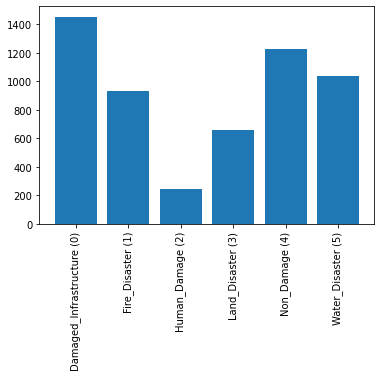

In [86]:
dist = count_dist_classes(path, data)
plot_dist(dist)

In [89]:
master_path = path
image_folder = 'Damaged_Infrastructure'

for i in range(10):
  name = f'collage_{image_folder}_{i}.png'
  path_to_save = os.path.join(master_path, image_folder, name)
  sample_image = make_random_collages(
      master_path = master_path,
      image_folder_path = image_folder,
      delete_samples = True,
      save_image = path_to_save
  )

Samples deleted
Samples deleted
Samples deleted
Samples deleted
Samples deleted
Samples deleted
Samples deleted
Samples deleted
Samples deleted
Samples deleted


Damaged_Infrastructure (0) : 1205
Fire_Disaster (1) : 933
Human_Damage (2) : 241
Land_Disaster (3) : 657
Non_Damage (4) : 1228
Water_Disaster (5) : 1035


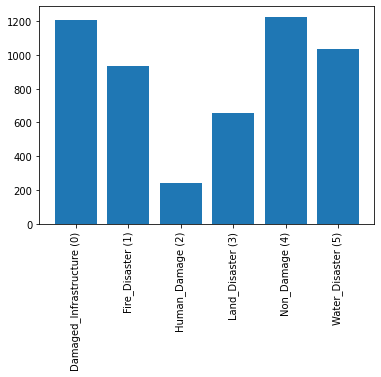

In [90]:
dist = count_dist_classes(path, data)
plot_dist(dist)

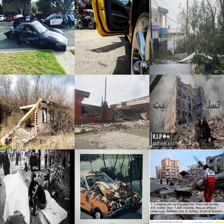

In [97]:
Image.open('/content/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/collage_Damaged_Infrastructure_19.png')

### **Up sampling the images which is deficient with augmentations + collages**

In [138]:
'''
steps:
1. first take some images and randomly make collages (WITHOUT DELETIING)
2. secondly randomly augment those and upsample that
'''

# for Human Damage folder

master_path = path
image_folder = 'Human_Damage'

for i in range(700):
  name = f'collage_{image_folder}_{i}.png'
  path_to_save = os.path.join(master_path, image_folder, name)
  try:
    sample_image = make_random_collages(
        master_path = master_path,
        image_folder_path = image_folder,
        save_image = path_to_save
    )
  except IsADirectoryError as e:
    print(e)
    print('skipping')

In [140]:
'''
steps:
1. first take some images and randomly make collages (WITHOUT DELETIING)
2. secondly randomly augment those and upsample that
'''

# for Land Disaster folder

master_path = path
image_folder = 'Land_Disaster'

for i in range(500):
  name = f'collage_{image_folder}_{i}.png'
  path_to_save = os.path.join(master_path, image_folder, name)
  try:
    sample_image = make_random_collages(
        master_path = master_path,
        image_folder_path = image_folder,
        save_image = path_to_save
    )
  except IsADirectoryError as e:
    print(e)
    print('skipping')

Damaged_Infrastructure (0) : 1205
Fire_Disaster (1) : 933
Human_Damage (2) : 940
Land_Disaster (3) : 1157
Non_Damage (4) : 1228
Water_Disaster (5) : 1035


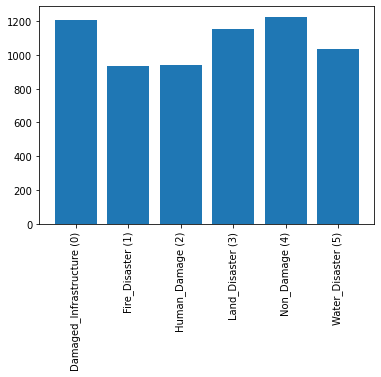

In [141]:
dist = count_dist_classes(path, data)
plot_dist(dist)

In [143]:
cd ..

/content/Comprehensive Disaster Dataset(CDD)


In [146]:
cd ..

/content


In [149]:
!zip -r Comprehensive Disaster Dataset(CDD) . -i complete_data.zip

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `zip -r Comprehensive Disaster Dataset(CDD) . -i complete_data.zip'


In [150]:
!zip -r /content/final.zip /content/Comprehensive\ Disaster\ Dataset\(CDD\)

Streaming output truncated to the last 5000 lines.
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0813.png (deflated 0%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0720.png (deflated 0%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0671.png (deflated 0%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0677.png (deflated 0%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0188.png (deflated 0%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0232.png (deflated 1%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0974.png (deflated 1%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0855.png (deflated 0%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0936.png (deflated 1%)
  adding: content/Comprehensive Disaster Dataset(CDD)/Water_Disaster/03_0592.png (deflated 0%)

In [151]:
cp final.zip gdrive/MyDrive/